# Prediction of tumor immune cell infiltration based on extracellular matrix organization

In [1]:
%matplotlib inline
# Import modules
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

import scipy.stats as stats

from sklearn.metrics import accuracy_score#, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz

import graphviz

# Local modules
import constantes
import auxiliary
import plots
import ExtractMap

## Lecture du jeu de données

Les jeux de données d'intérêts, ont été composés à l'aide de différents descripteurs extraits par une convolution (une fenêtre de **n*****n**pixels que l'on fait glisser sur notre image) réalisée sur des images de coupe histologique de cellules tumorales. C'est à dire qu'à différentes position d'une image on extrait des descripteurs afin de constituer notre jeu de données.  

**n** est une valeur correspondant à des fenêtres allant de tailles 20, 60, 100 à 140 pixels.  

Les expériences sur les cellules tumorales ont été réalisées sous différentes conditions, avec la présence des macrophages (WT) et en déplétant les macrophages (KI).

In [2]:
# Path to dataframes
filepath_wt = "../data/WTconcatenate.csv.gz"
filepath_ki = "../data/KIconcatenate.csv.gz"

# WT & KI labels
WT_label = constantes.WT[1]
KI_label = constantes.KI[1]

# Read dataframes
df_wt = auxiliary.read_dataframe(filepath_wt, low_memory=False)
df_ki = auxiliary.read_dataframe(filepath_ki, low_memory=False)
df_ki[constantes.KI[0]] = KI_label  # correct column

### Information sur les descripteurs du jeu de données

| Variable | type | Description |  
| --- | --- | --- |  
| **Condition** | (str) | Cette variable informe sur le phénotype Wild Type (WT) ou déplété en macrophage (KI) de l'environnement micro-tumorale observé. |
| **FileName** | (str) | Nom du fichier sur lequel sont réalisés les analyses. |
| **X** | (int) | Position en X de la fenêtre. <br> Entier naturel strictement positif. |
| **Y** | (int) | Position en Y de la fenêtre. <br> Entier naturel strictement positif. |
| **Coherency** | (float) | Désordre des fibres contenu au sein de la fenêtre. <br> C'est une variable quantitative qui varie entre 0 (total désordre) et 1 (ordre total). |
| **Energy** | (float) | **A VERIFIER** <br> Cette variable quantitative informe sur le contraste présent au sein de la fenêtre. <br> Cette variable varie entre 0 (aucun contraste) et 1 (fort contraste)|
| **MeanInt** | (float) | Intensité moyenne au sein de la fenêtre |
| **VarInt** | (float) | Variance de l'intensité au sein de la fenêtre. |
| **Density** | (float) | Variable quantitative qui permet de quantifier les fibres au sein de la fenêtre. <br>Elle varie entre 0 lorsqu'il n'y a aucune fibre, et 1 lorsque la fenêtre est entièrement composée de fibres. |
| **VarDensity** | (float) | Variance calculée sur la densité. |
| **OrientationRef** | (float) | Orientation des fibres par rapport à une rotation de référence sur une fenêtre plus large. <br> Varie entre $-\pi$ et $\pi$. |
| **Dist** | (float) | Distance de la fenêtre par rapport à l'extremité de la paroi cellulaire |
| **Angle** | (float) | Angle par rapport au bord de la cellule |
| **Mask** | (bool) | Variable catégorielle indiquant si l'observation se situe au sein de la tumeur (Mask=1) ou en dehors de la tumeur (Mask=0). |
| **Type** | (str) | Variable catégorielle informant sur le type cellulaire auquel on s'intéresse, CD3 pour les lymphocytes T ou Ly6 pour les neutrophiles. |
| **Cells** | (int)/(float)| Entier positif correspondant au nombre de cellule immunitaire (en fonction de la variable Type) observé au sein de la fenêtre. |
| **MinDist** | (float) | Distance à la cellule voisine plus proche. |
| **MedDist** | (float) | Distance median par rapport aux valeurs de distances des cellules immunitaires voisines les plus proches. |
| **CellArea** | (float) | Aire de la cellule immunitaire. |
| **CellEcc** | (float) | Excentricité de la cellule immunitaire. Cette variable permet de décrire la forme de la cellule (allongée/arrondie). |
| **Cells100um** | (float) | Nombre de cellules immunitaire à 100um. |
| **MinDist100um** | (float) | **A VERIFIER (différence avec MinDist)** |
| **MedDist100um** | (float) | Distance mediam par rapport au distances des cellules immunitaires voisines à 100um.|
| **CellArea100um** | (float) | **A VERIFIER (l'aire est-elle calculée sur l'ensemble des cellules à 100um?)**|
| **CellEcc100um** | (float) | |
| **Frac** | (float) | La fractalité est une mesure de la répétition des patterns/motifs au sein de la fenêtre. |

### Conversion du type des colonnes

On attribut à chaque colonne un type spécifique afin de spécifier l'espace mémoire que celles-ci peuvent prendre. Les entier, sont convertis en type int32 (ou uint32 pour les variables strictements positives).  

Les variables quantitatives à valeurs flottantes sont converties en float64.  
Sont convertis en np.object, les variables représentant des chaînes de caractères (phenotype WT/KI, nom du fichier, type cellulaire Ly6/CD3).  

Ces conversions sont pratiques afin de clarifier les types associés aux variables, et pour la gestion de l'espace mémoire que l'on assigne à celles-ci.

In [3]:
# Associate the corresponding type to each columns
data_type = {
    **dict.fromkeys(constantes.str_columns, object),
    **dict.fromkeys(constantes.unsigned_columns, np.uint32),
    **dict.fromkeys(constantes.float_columns, np.float64),
    **dict.fromkeys(constantes.int_columns, np.int32)
}

df_wt = df_wt.astype(data_type)
df_ki = df_ki.astype(data_type)

# Concatenate both dataset WT & KI
df_all = pd.concat([df_wt, df_ki])

In [4]:
print("----- Jeu de données complet -----")
print(f"Nombre de lignes au sein du jeu de données: {df_all.shape[0]:_}")
print(f"Nombre de colonnes au sein du jeu de données: {df_all.shape[1]:_}\n")

----- Jeu de données complet -----
Nombre de lignes au sein du jeu de données: 6_697_691
Nombre de colonnes au sein du jeu de données: 50



In [5]:
# Type of each column
df_all.dtypes.to_frame().T

,Condition,FileName,X,Y,Coherency100,Energy100,MeanInt100,VarInt100,Density100,VarDensity100,...,MinDist,MedDist,CellArea,CellEcc,Cells100um,MinDist100um,MedDist100um,CellArea100um,CellEcc100um,Frac
0,object,object,uint32,uint32,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [6]:
# First rows in dataframe
df_all.head()

,Condition,FileName,X,Y,Coherency100,Energy100,MeanInt100,VarInt100,Density100,VarDensity100,...,MinDist,MedDist,CellArea,CellEcc,Cells100um,MinDist100um,MedDist100um,CellArea100um,CellEcc100um,Frac
0,WT,./12a_FWT155_Ly6G_SHG.tif,23,29,0.160,0.000084,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,WT,./12a_FWT155_Ly6G_SHG.tif,63,29,0.167,0.000103,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,WT,./12a_FWT155_Ly6G_SHG.tif,103,29,0.176,0.000140,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,WT,./12a_FWT155_Ly6G_SHG.tif,143,29,0.185,0.000197,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,WT,./12a_FWT155_Ly6G_SHG.tif,183,29,0.191,0.000275,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [7]:
# Quantitative data description
df_all_desc = df_all.describe()
df_all_desc

,X,Y,Coherency100,Energy100,MeanInt100,VarInt100,Density100,VarDensity100,Coherency140,Energy140,...,MinDist,MedDist,CellArea,CellEcc,Cells100um,MinDist100um,MedDist100um,CellArea100um,CellEcc100um,Frac
count,6.697691e+06,6.697691e+06,6.697691e+06,6.697691e+06,6.662657e+06,6.662657e+06,6.662657e+06,6.662657e+06,6.697691e+06,6.697691e+06,...,3.226775e+06,3.226775e+06,3.226775e+06,3.226775e+06,6.697691e+06,3.226775e+06,3.226775e+06,3.226775e+06,3.226775e+06,1.616940e+06
mean,7.168084e+03,7.305759e+03,1.524157e-01,8.355423e-02,5.921653e+00,7.108386e+01,1.688810e-01,3.661304e-02,1.553567e-01,1.032972e-01,...,2.811799e+00,5.926502e+00,6.276004e+00,1.463598e-01,3.535534e+00,1.859412e+00,3.888546e+00,4.992713e+00,1.161127e-01,1.825627e+00
std,4.662676e+03,4.679211e+03,1.254165e-01,1.410929e-01,1.541357e+01,2.937218e+02,3.220997e-01,7.174971e-02,1.209173e-01,1.606857e-01,...,8.781794e+00,1.920741e+01,1.779285e+01,3.911100e-01,9.522765e+00,3.548346e+00,8.903150e+00,9.948160e+00,2.209289e-01,2.355935e-01
min,2.000000e+01,2.000000e+01,1.414000e-28,2.961000e-30,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.076000e-30,5.413000e-34,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.757961e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.356107e-02
25%,3.437000e+03,3.464000e+03,6.200000e-02,9.953500e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.900000e-02,3.000000e-03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.734743e+00
50%,6.702000e+03,6.794000e+03,1.260000e-01,2.500000e-02,8.000000e-02,4.430000e-01,0.000000e+00,0.000000e+00,1.310000e-01,3.500000e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.932144e+00
75%,1.015800e+04,1.050100e+04,2.130000e-01,9.600000e-02,3.966000e+00,1.816100e+01,1.180000e-01,2.700000e-02,2.140000e-01,1.260000e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.210000e+00,2.888323e+00,6.228653e+00,5.906250e+00,1.579000e-01,1.995705e+00
max,2.934600e+04,2.127100e+04,9.260000e-01,9.990000e-01,2.545490e+02,1.375575e+04,1.000000e+00,2.500000e-01,9.190000e-01,9.990000e-01,...,7.919362e+02,1.987163e+03,5.697500e+02,6.171300e+00,1.137400e+02,4.438150e+01,8.259579e+02,3.065000e+02,3.749700e+00,2.000000e+00


## Lymphocytes T

D'après les observations, les lymphocytes T sont souvent retrouvées dans des zones avec des fibres. Notre étude portera sur la corrélation des différents descripteurs (forme de la matrice, distribution) avec le nombre de lymphocyte T afin d'étudier quels sont les caractéristiques qui permettent de prédire une zone plus ou moins riche en Lymphocytes T.

**Dataset definition in and outside tumor**

In [8]:
# T Cells only
df_cd3 = df_all[df_all[constantes.CD3[0]] == constantes.CD3[1]]  # T Cells
df_cd3_in_tumor = df_cd3[df_cd3[constantes.IN_TUMOR[0]] == constantes.IN_TUMOR[1]]  # T Cells & in tumor
df_cd3_out_tumor = df_cd3[df_cd3[constantes.OUT_TUMOR[0]] == constantes.OUT_TUMOR[1]]  # T Cells & outside tumor

In [9]:
# Per file description
df_cd3_perfile_in_tumor = (
    df_cd3_in_tumor[["FileName", "Condition"]]
    .groupby(["FileName"]).value_counts().to_frame()
    .reset_index(level=1).sort_values(by="Condition", ascending=False)
    .rename(columns={"count": "Nobs"})
)
# Add Name column
df_cd3_perfile_in_tumor["Name"] = [
    filename[2:filename.find(".tif")] for filename in df_cd3_perfile_in_tumor.index
]

# Add Cells count
df_cd3_perfile_in_tumor = df_cd3_perfile_in_tumor.join(
    df_cd3_in_tumor[["FileName", "Cells"]].groupby(["FileName"]).sum()
)

# Add Cells count proportion (Cells/Nobs)
df_cd3_perfile_in_tumor["percent_Cells"] = (
    df_cd3_perfile_in_tumor["Cells"] / df_cd3_perfile_in_tumor["Nobs"]
)

# Add Cells100um count
df_cd3_perfile_in_tumor = df_cd3_perfile_in_tumor.join(
    df_cd3_in_tumor[["FileName", "Cells100um"]].groupby(["FileName"]).sum()
)

# Add Cells100um count proportion (Cells100um/Nobs)
df_cd3_perfile_in_tumor["percent_Cells100um"] = (
    df_cd3_perfile_in_tumor["Cells100um"] / df_cd3_perfile_in_tumor["Nobs"]
)

# Add DObs, difference in observation (Nobs - Cells)
df_cd3_perfile_in_tumor["DObs"] = (
    df_cd3_perfile_in_tumor["Nobs"] - df_cd3_perfile_in_tumor["Cells"]  # Observations - Number of T Cells
)

# Reorder columns
df_cd3_perfile_in_tumor = df_cd3_perfile_in_tumor.reindex(
    columns=["Name", "Condition", "Nobs", "DObs", "Cells", "percent_Cells", "Cells100um", "percent_Cells100um"]
)

df_cd3_perfile_in_tumor.head()

,Name,Condition,Nobs,DObs,Cells,percent_Cells,Cells100um,percent_Cells100um
FileName,,,,,,,,
./MAX_12b_187_CD3eFITC.tif_SHG.tif,MAX_12b_187_CD3eFITC,WT,71965,50517.0,21448.0,0.298034,640002.88,8.893252
./FWT_507_down_CD3FITC.tif_max.tif_SHG.tif,FWT_507_down_CD3FITC,WT,38647,30264.0,8383.0,0.216912,248582.40,6.432127
./MAX_12b_189_CD3eFITC.tif_SHG.tif,MAX_12b_189_CD3eFITC,WT,75969,58501.0,17468.0,0.229936,522392.09,6.876385
./MAX_12b_184_CD3eFITC.tif_SHG.tif,MAX_12b_184_CD3eFITC,WT,62492,45912.0,16580.0,0.265314,496919.17,7.951725
./MAX_12b_FWT331_CD3_SHG.tif,MAX_12b_FWT331_CD3_SHG,WT,82718,75061.0,7657.0,0.092568,229221.19,2.771116


In [10]:
# Mask (for easier access with conditional parameters)
## inside tumor
mask_cd3_wt_in = df_cd3_in_tumor[constantes.WT[0]] == WT_label
mask_cd3_ki_in = df_cd3_in_tumor[constantes.KI[0]] == KI_label
mask_cd3_density_in = df_cd3_in_tumor['Density20'] > 0
mask_cd3_cells_in = df_cd3_in_tumor['Cells'] > 0
mask_cd3_cells100um_in = df_cd3_in_tumor['Cells100um'] > 0

### per file
mask_cd3_perfile_wt_in = df_cd3_perfile_in_tumor[constantes.WT[0]] == WT_label
mask_cd3_perfile_ki_in = df_cd3_perfile_in_tumor[constantes.KI[0]] == KI_label

## outside tumor
mask_cd3_wt_out = df_cd3_out_tumor[constantes.WT[0]] == WT_label
mask_cd3_ki_out = df_cd3_out_tumor[constantes.KI[0]] == KI_label
mask_cd3_density_out = df_cd3_out_tumor['Density20'] > 0
mask_cd3_cells_out = df_cd3_out_tumor['Cells'] > 0
mask_cd3_cells100um_out = df_cd3_out_tumor['Cells100um'] > 0

# Associated color to labels
color_out = sns.color_palette("Set1")[0]
color_in = sns.color_palette("Set1")[2]
color_wt = sns.color_palette("Set2")[0]
color_ki = sns.color_palette("Set2")[1]

In [11]:
# Table with count by condition
table_perfile_condition = df_cd3_perfile_in_tumor["Condition"].value_counts()

# Print
print("----- Lymphocytes T -----")
print(
    f"Nombre d'images uniques : {df_cd3_perfile_in_tumor.shape[0]}\n"
    f"Nombre de tissus WT : {table_perfile_condition[WT_label]}\n"
    f"Nombre de tissus KI : {table_perfile_condition[KI_label]}\n\n"
    f"Nombre de colonnes au sein du jeu de données : {df_cd3_in_tumor.shape[1]}\n"
    f"Nombre d'observations en dehors de la tumeur (Mask=0): {df_cd3_out_tumor.shape[0]}\n"
    f"Nombre d'observations au sein de la tumeur (Mask=1): {df_cd3_in_tumor.shape[0]}\n\n"
    f"Nombre d'observations avec fibres (Density20>0) = {sum(mask_cd3_density_in)}\n"
    f"Nombre d'observations sans fibres (Density20<=0) = {sum(~mask_cd3_density_in)}\n"
)

print(
    f"Colonnes du jeu de données :\n",
    auxiliary.format_by_rows(
        df_cd3_in_tumor.columns.values,
        ncol=6, spacing=3
    )
)

----- Lymphocytes T -----
Nombre d'images uniques : 34
Nombre de tissus WT : 14
Nombre de tissus KI : 20

Nombre de colonnes au sein du jeu de données : 50
Nombre d'observations en dehors de la tumeur (Mask=0): 2028501
Nombre d'observations au sein de la tumeur (Mask=1): 1867864

Nombre d'observations avec fibres (Density20>0) = 686933
Nombre d'observations sans fibres (Density20<=0) = 1180931

Colonnes du jeu de données :
 Condition           FileName            X                   Y                   Coherency100        Energy100           
MeanInt100          VarInt100           Density100          VarDensity100       Coherency140        Energy140           
MeanInt140          VarInt140           Density140          VarDensity140       Coherency20         Energy20            
MeanInt20           VarInt20            Density20           VarDensity20        Coherency60         Energy60            
MeanInt60           VarInt60            Density60           VarDensity60        Orientat

In [12]:
# Descriptif statistiques sur les descripteurs quantitatifs
df_cd3_in_tumor_desc = df_cd3_in_tumor.describe()
df_cd3_in_tumor_desc

,X,Y,Coherency100,Energy100,MeanInt100,VarInt100,Density100,VarDensity100,Coherency140,Energy140,...,MinDist,MedDist,CellArea,CellEcc,Cells100um,MinDist100um,MedDist100um,CellArea100um,CellEcc100um,Frac
count,1.867864e+06,1.867864e+06,1.867864e+06,1.867864e+06,1.867864e+06,1.867864e+06,1.867864e+06,1.867864e+06,1.867864e+06,1.867864e+06,...,1.867864e+06,1.867864e+06,1.867864e+06,1.867864e+06,1.867864e+06,1.867864e+06,1.867864e+06,1.867864e+06,1.867864e+06,683899.000000
mean,7.411356e+03,7.312532e+03,1.564972e-01,8.476342e-02,7.231138e+00,9.949139e+01,2.484129e-01,5.332157e-02,1.528391e-01,1.051589e-01,...,2.697225e+00,5.650944e+00,6.194308e+00,1.436338e-01,7.080074e+00,1.821631e+00,3.774014e+00,4.978345e+00,1.148639e-01,1.811827
std,4.179735e+03,3.604892e+03,1.022133e-01,1.065103e-01,1.293113e+01,3.617681e+02,3.652177e-01,7.982542e-02,9.813852e-02,1.241132e-01,...,8.575892e+00,1.883151e+01,1.788195e+01,3.880424e-01,1.259818e+01,3.493118e+00,8.781211e+00,1.002486e+01,2.202592e-01,0.248390
min,2.620000e+02,4.620000e+02,2.414000e-25,4.824000e-28,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.246000e-16,2.469000e-19,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.951939e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.053561
25%,4.427000e+03,4.472000e+03,8.200000e-02,1.800000e-02,1.140000e-01,6.470000e-01,0.000000e+00,0.000000e+00,8.100000e-02,2.400000e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.700811
50%,6.758000e+03,6.825000e+03,1.360000e-01,4.900000e-02,1.490000e+00,8.424000e+00,1.900000e-02,3.000000e-03,1.340000e-01,6.200000e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.210000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.927938
75%,9.634000e+03,9.798000e+03,2.110000e-01,1.060000e-01,9.274000e+00,3.738300e+01,4.310000e-01,8.700000e-02,2.060000e-01,1.360000e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.260000e+00,2.723800e+00,5.893963e+00,5.500000e+00,1.503000e-01,1.996414
max,2.846600e+04,1.878300e+04,8.510000e-01,9.990000e-01,1.998890e+02,1.375575e+04,1.000000e+00,2.500000e-01,7.440000e-01,9.990000e-01,...,7.919362e+02,1.987163e+03,5.697500e+02,6.171300e+00,1.016400e+02,4.438150e+01,8.259579e+02,2.930000e+02,3.749700e+00,2.000000


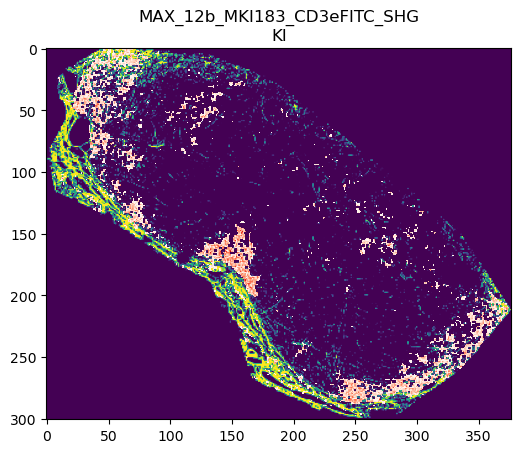

In [13]:
# Cell with density
i = 14
name = df_cd3_perfile_in_tumor.index[i]
matrix_density = ExtractMap.ExtractMap(df_cd3_in_tumor, "Density20", chosen_file=name)  # Show density
matrix_cells = ExtractMap.ExtractMap(df_cd3_in_tumor, "Cells", chosen_file=name)  # Show T Cells
matrix_cells[matrix_cells == 0] = np.nan

# Plot
fig, ax = plt.subplots(figsize=(6, 5))
ax.imshow(matrix_density, cmap='viridis')
ax.imshow(matrix_cells, cmap=plt.cm.Reds)
ax.set_title(
    f"{df_cd3_perfile_in_tumor['Name'].iloc[i]}\n"
    f"{df_cd3_perfile_in_tumor['Condition'].iloc[i]}"
)
plt.show()

## Comparaison des distribution entre WT et KI (CD64-hDTR)

On s'intéresse ici à la distribution des différents descripteurs selon si le tissu est de phénotype WT (en présence naturel de macrophages) et lorsque le tissu est de phénotype KI (déplété en macrophage).

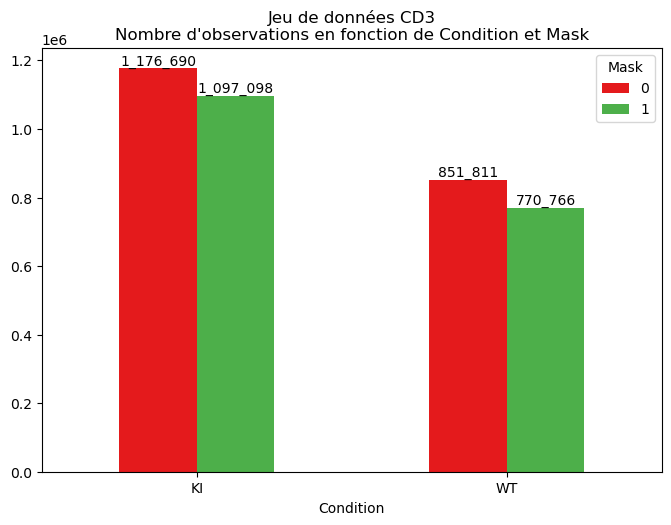

In [14]:
# Nombre d'observations au sein des classes Condition & Mask
table_condition_mask = pd.crosstab(df_cd3["Condition"], df_cd3["Mask"])

# Plot
ax = table_condition_mask.plot(kind="bar", rot=0, color=[color_out, color_in], figsize=(8, 5.5))
ax.set_title(
    "Jeu de données CD3\n"
    "Nombre d'observations en fonction de Condition et Mask"
)
for container in ax.containers:
    ax.bar_label(container, fontsize=10, fmt=lambda k: f"{k:_.0f}")

/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

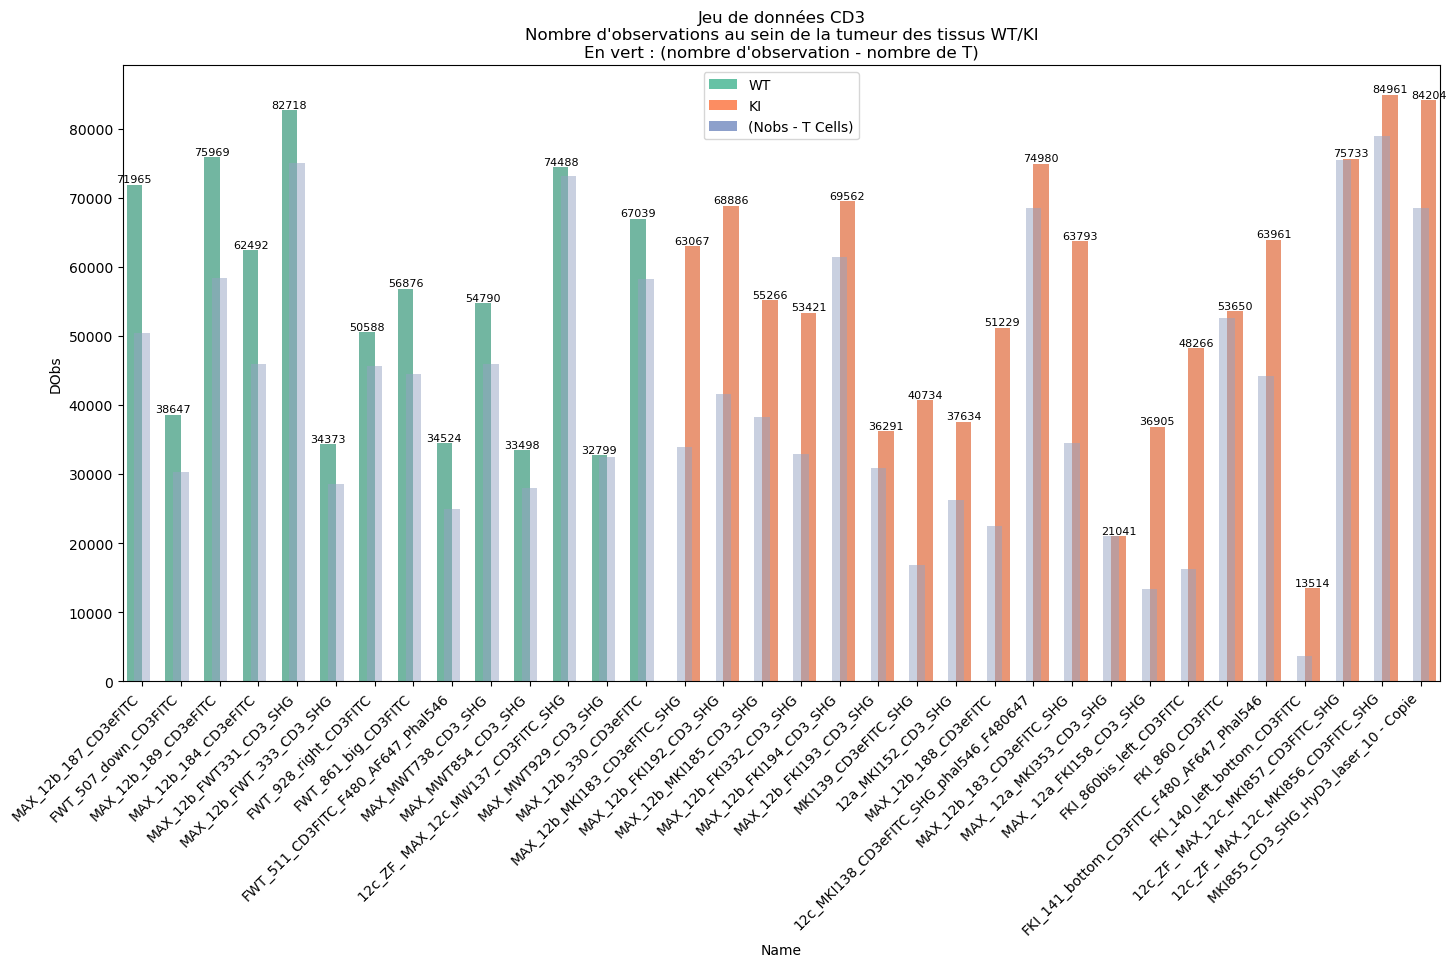

In [15]:
# Number of observation in WT & KI
figs_to_close = []
fig, ax = plt.subplots(figsize=(17, 8))
sns.barplot(
    ax=ax, data=df_cd3_perfile_in_tumor,
    x="Name", y="Nobs", hue="Condition", palette="Set2"
)

ax.bar_label(ax.containers[0], fontsize=8)
ax.bar_label(ax.containers[1], fontsize=8)

ax.set_title(
    "Jeu de données CD3\n"
    "Nombre d'observations au sein de la tumeur des tissus WT/KI\n"
    "En vert : (nombre d'observation - nombre de T)"
)

ax.set_ylabel(
    "Nombre d'observations\n"
    "Delta obs (Nombre d'observation - Nombre T Cells) (en vert)"
)

# DObs (Observation - T Cells)
sns.barplot(
    ax=ax, data=df_cd3_perfile_in_tumor, x="Name", y="DObs",
    width=0.4, alpha=0.5, dodge=False,
    color=sns.color_palette("Set2")[2]
)
ax.legend(
    handles=[
        Patch(facecolor=color_wt, label=WT_label),
        Patch(facecolor=color_ki, label=KI_label),
        Patch(facecolor=sns.color_palette("Set2")[2], label='(Nobs - T Cells)')
    ]
)

plt.xticks(rotation=45, ha='right')

figs_to_close.append(fig)

/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

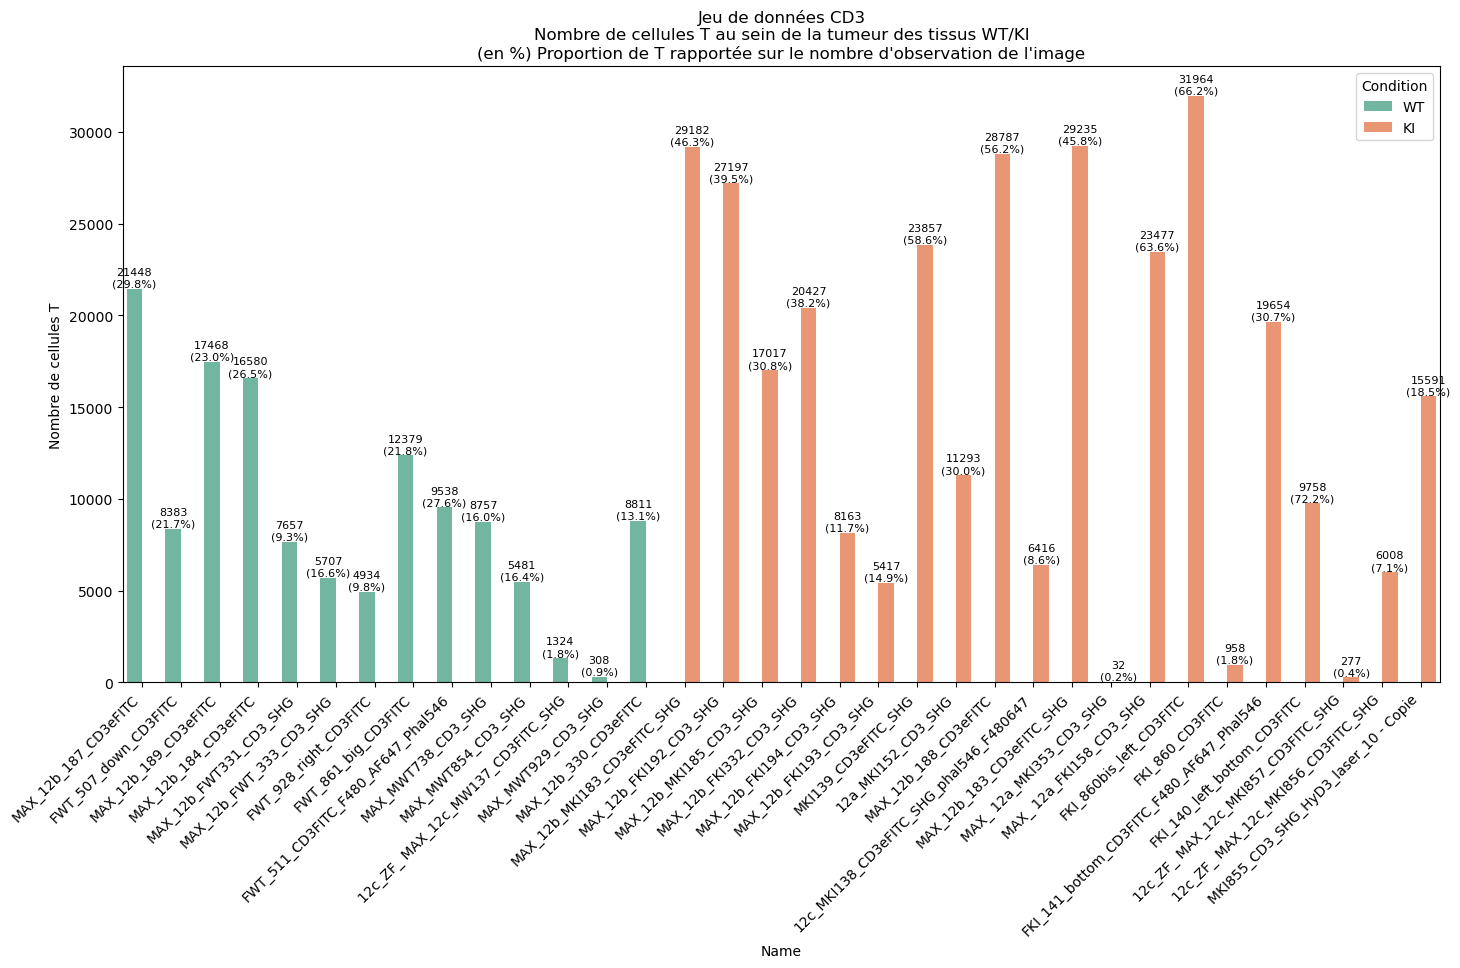

In [16]:
# Number of T Cells in WT & KI
fig, ax = plt.subplots(figsize=(17, 8))
sns.barplot(
    ax=ax, data=df_cd3_perfile_in_tumor,
    x="Name", y="Cells", hue="Condition", palette="Set2"
)

labels_1 = [
    f'{v.get_height():.0f}\n'
    f'({df_cd3_perfile_in_tumor.iloc[idx]["percent_Cells"]*100:.1f}%)'\
    for idx, v in enumerate(ax.containers[0])
]
ax.bar_label(ax.containers[0], labels=labels_1, fontsize=8)

labels_2 = [
    f'{v.get_height():.0f}\n'
    f'({df_cd3_perfile_in_tumor.iloc[idx]["percent_Cells"]*100:.1f}%)'\
    for idx, v in enumerate(ax.containers[1])
]
ax.bar_label(ax.containers[1], labels=labels_2, fontsize=8)

ax.set_title(
    "Jeu de données CD3\n"
    "Nombre de cellules T au sein de la tumeur des tissus WT/KI\n"
    "(en %) Proportion de T rapportée sur le nombre d'observation de l'image"
)
ax.set_ylabel("Nombre de cellules T")
plt.xticks(rotation=45, ha='right')

figs_to_close.append(fig)

/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


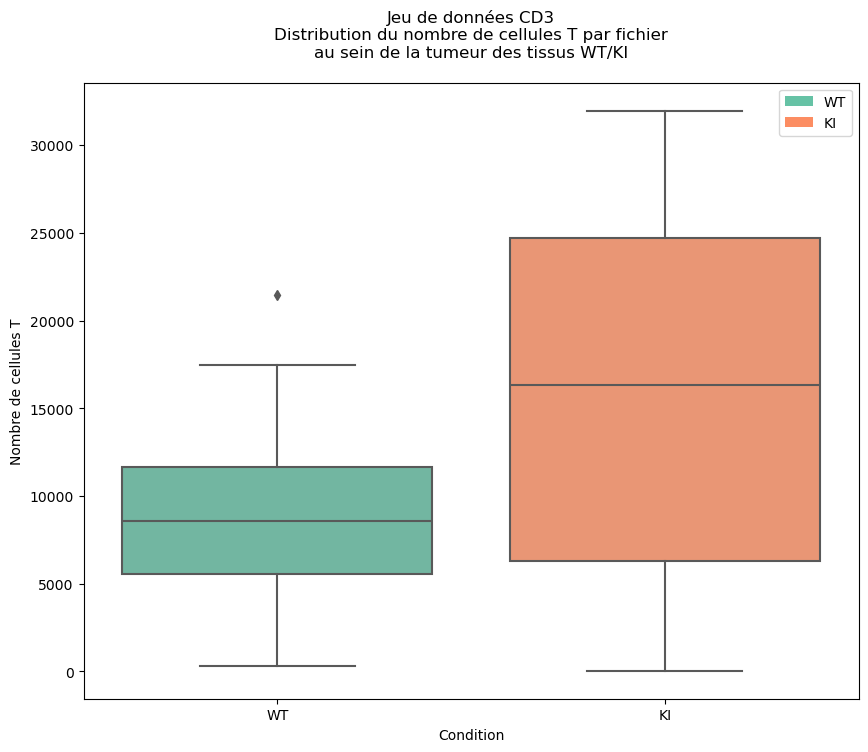

In [17]:
# Boxplot, T Cells number selon la condition
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(ax=ax, data=df_cd3_perfile_in_tumor, x="Condition", y="Cells", palette="Set2")
ax.set_title(
    "Jeu de données CD3\n"
    "Distribution du nombre de cellules T par fichier\n"
    "au sein de la tumeur des tissus WT/KI\n"
)
ax.set_ylabel("Nombre de cellules T")
ax.legend(
    handles=[
        Patch(facecolor=color_wt, label=WT_label),
        Patch(facecolor=color_ki, label=KI_label),
    ]
)

# Append figure
figs_to_close.append(fig)

In [18]:
# Save created plot to PDF
#plots.to_pdf("test1", figs_to_close, bbox_inches="tight")  # Save figures
#[plt.close(fig) for fig in figs_to_close]  # Close figures

In [19]:
# Statistics
alpha = 0.05
nobs_wt_ki = stats.ttest_ind(
    df_cd3_perfile_in_tumor[mask_cd3_perfile_wt_in]["Nobs"],
    df_cd3_perfile_in_tumor[mask_cd3_perfile_ki_in]["Nobs"],
    equal_var = False
)  # No differences between number of value distribution in the two condition

cells_wt_ki = stats.ttest_ind(
    df_cd3_perfile_in_tumor[mask_cd3_perfile_wt_in]["Cells"],
    df_cd3_perfile_in_tumor[mask_cd3_perfile_ki_in]["Cells"],
    equal_var = False
)  # There is a significative difference between T-cells distribution depending on the two condition

cells100um_wt_ki = stats.ttest_ind(
    df_cd3_perfile_in_tumor[mask_cd3_perfile_wt_in]["Cells100um"],
    df_cd3_perfile_in_tumor[mask_cd3_perfile_ki_in]["Cells100um"],
    equal_var = False
)  # There is a significative difference between Cells100um distribution depending on the two condition

metrics_cd3_perfile_wt_in_nobs = auxiliary.get_metrics(df_cd3_perfile_in_tumor[mask_cd3_perfile_wt_in]["Nobs"])
metrics_cd3_perfile_wt_in_cells = auxiliary.get_metrics(df_cd3_perfile_in_tumor[mask_cd3_perfile_wt_in]["Cells"])
metrics_cd3_perfile_wt_in_cells100um = auxiliary.get_metrics(df_cd3_perfile_in_tumor[mask_cd3_perfile_wt_in]["Cells100um"])

metrics_cd3_perfile_ki_in_nobs = auxiliary.get_metrics(df_cd3_perfile_in_tumor[mask_cd3_perfile_ki_in]["Nobs"])
metrics_cd3_perfile_ki_in_cells = auxiliary.get_metrics(df_cd3_perfile_in_tumor[mask_cd3_perfile_ki_in]["Cells"])
metrics_cd3_perfile_ki_in_cells100um = auxiliary.get_metrics(df_cd3_perfile_in_tumor[mask_cd3_perfile_ki_in]["Cells100um"])

# Print comparison results between WT and KI
print("----- Tests statistiques en fonction des conditions WT/KI -----\n")
print(
    f"Par rapport au nombre d'observations :\n"
    f"{'':4s}mean_wt={metrics_cd3_perfile_wt_in_nobs['mean']:.2f} \u00B1 {metrics_cd3_perfile_wt_in_nobs['std']:.2f}{'':4s}"
    f"mean_ki={metrics_cd3_perfile_ki_in_nobs['mean']:.2f} \u00B1 {metrics_cd3_perfile_ki_in_nobs['std']:.2f}{'':4s}"
    f"p-value={nobs_wt_ki[1]:.3f}{'':4s}"
    f"signif={nobs_wt_ki[1]<alpha}\n"
)
print(
    f"Par rapport au nombre de cellules T :\n\t"
    f"{'':4s}mean_wt={metrics_cd3_perfile_wt_in_cells['mean']:.2f} \u00B1 {metrics_cd3_perfile_wt_in_cells['std']:.2f}{'':4s}"
    f"mean_ki={metrics_cd3_perfile_ki_in_cells['mean']:.2f} \u00B1 {metrics_cd3_perfile_ki_in_cells['std']:.2f}{'':4s}"
    f"p-value={cells_wt_ki[1]:.3f}{'':4s}"
    f"signif={cells_wt_ki[1]<alpha}\n"
)

print(
    f"Par rapport au nombre de cellules à 100um :\n\t"
    f"{'':4s}mean_wt={metrics_cd3_perfile_wt_in_cells100um['mean']:.2f} \u00B1 {metrics_cd3_perfile_wt_in_cells100um['std']:.2f}{'':4s}"
    f"mean_ki={metrics_cd3_perfile_ki_in_cells100um['mean']:.2f} \u00B1 {metrics_cd3_perfile_ki_in_cells100um['std']:.2f}{'':4s}"
    f"p-value={cells100um_wt_ki[1]:.3f}{'':4s}"
    f"signif={cells100um_wt_ki[1]<alpha}\n"
)

----- Tests statistiques en fonction des conditions WT/KI -----

Par rapport au nombre d'observations :
    mean_wt=55054.71 ± 17252.36    mean_ki=54854.90 ± 19140.98    p-value=0.976    signif=False

Par rapport au nombre de cellules T :
	    mean_wt=9198.21 ± 5805.07    mean_ki=15735.50 ± 10482.68    p-value=0.031    signif=True

Par rapport au nombre de cellules à 100um :
	    mean_wt=273542.63 ± 173561.14    mean_ki=469750.92 ± 314100.33    p-value=0.031    signif=True



In [20]:
# Save multiple Cells figure to a PDF
def save_cells(data, data_perfile, filename="test.pdf"):
    figs_to_close = []
    for idx, name in enumerate(data_perfile.index):
        # Show Tumor Cell
        fig, ax = plt.subplots(figsize=(10, 8))
        matrix_density = ExtractMap.ExtractMap(data, "Density20", chosen_file=name)  # Show density
        matrix_cells = ExtractMap.ExtractMap(data, "Cells", chosen_file=name)  # Show T Cells
        matrix_cells[matrix_cells == 0] = np.nan

        # Title label
        label_name = data_perfile['Name'].iloc[idx]
        label_condition = data_perfile['Condition'].iloc[idx]
        label_nobs = data_perfile['Nobs'].iloc[idx]
        label_tcells = data_perfile['Cells'].iloc[idx]
        label_tcells_prop = data_perfile['percent_Cells'].iloc[idx]*100

        # Plot
        ax.imshow(matrix_density, cmap='viridis')
        ax.imshow(matrix_cells, cmap=plt.cm.Reds)
        ax.set_title(
            f"{label_name}\n"
            f"{label_condition}\n"
            f"Nombre de Cellules T : {label_tcells:_.0f} ({label_tcells_prop:.2f}%)\n"
            f"Nombre d'observations total : {label_nobs:_}"
        )

        figs_to_close.append(fig)
    
    plots.to_pdf(filename, figs_to_close)
    [plt.close(f) for f in figs_to_close]

save_cells(df_cd3_in_tumor, df_cd3_perfile_in_tumor, filename="test.pdf")

/tmp/ipykernel_321792/1686458752.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 8))


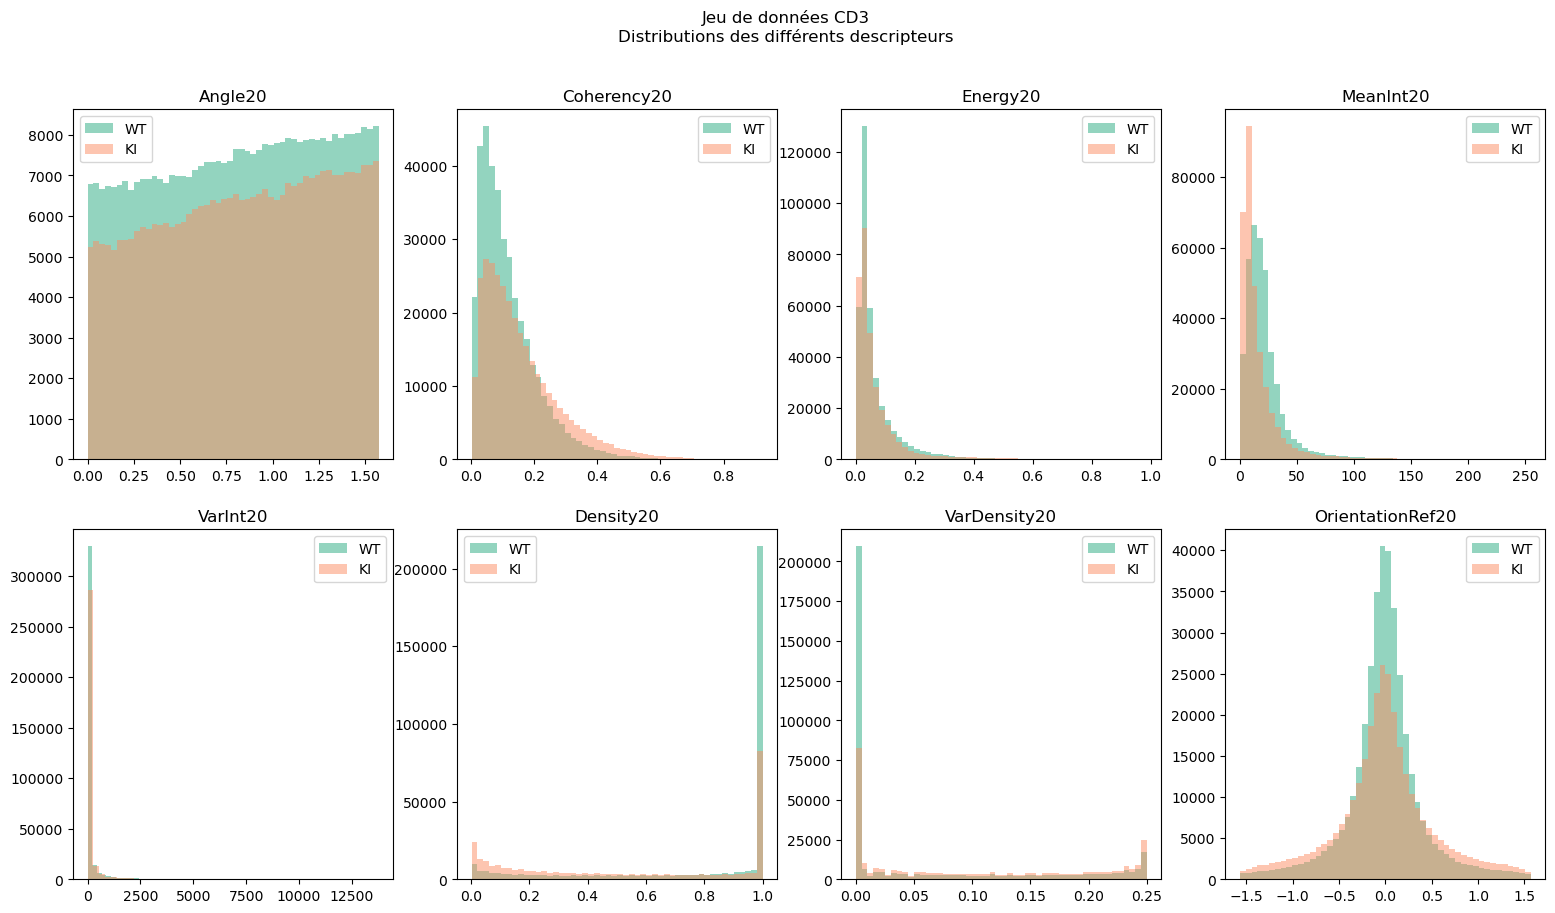

In [21]:
 pixel_size = 20
descriptors = ["Angle", "Coherency", "Energy", "MeanInt", "VarInt", "Density", "VarDensity", "OrientationRef"]
descriptors = [i+str(pixel_size) for i in descriptors]
fig, ax = plt.subplots(2, i2:=4, figsize=(19, 10))
fig.suptitle("Jeu de données CD3\n"
             "Distributions des différents descripteurs")

df_tmp = df_cd3_in_tumor[df_cd3_in_tumor["Density20"] > 0]
for i, des in enumerate(descriptors):
    idx0, idx1 = i//i2, i%i2
    actual_axis = ax[idx0][idx1]
    actual_axis.hist(df_tmp[df_tmp["Condition"] == WT_label][des], label=WT_label, bins=50, alpha=0.7, color=color_wt)
    actual_axis.hist(df_tmp[df_tmp["Condition"] == KI_label][des], label=KI_label, bins=50, alpha=0.5, color=color_ki)
    actual_axis.set_title(des)
    actual_axis.legend()

plt.show()

## Zones T+ ou enrichies en T

Les zones enrichies en T sont des régions peuplés en cellules immunitaires. Elle est définie lorsque le nombre de cellules immunitaires à 100um est supérieur à la moyenne de cette distribution.
Les zones T+ sont les régions pour lequel le nombre de cellules immunitaires à 100um est supérieur à 0.

In [22]:
# Create a new dataframe that will contain class attributes
df_cd3_zones_in = df_cd3_in_tumor.copy()

In [23]:
# Mask (already defined)
mask_cd3_wt_in
mask_cd3_ki_in
mask_cd3_density_in
mask_cd3_cells_in
mask_cd3_cells100um_in

# t enrichie & t plus
mask_t_plus = df_cd3_zones_in["Cells100um"] > 0
mask_t_enriched = df_cd3_zones_in["Cells100um"] > df_cd3_zones_in["Cells100um"].mean()
mask_t_enriched_2 = df_cd3_zones_in["Cells100um"] > df_cd3_zones_in[mask_t_plus]["Cells100um"].mean()

# Color
color_t_plus = sns.color_palette("Set2")[4]
color_t_enriched = sns.color_palette("Set2")[7]
color_t_enriched_2 = sns.color_palette("Set2")[3]

# Color palette
sns.color_palette("Set2")

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [24]:
# Initialize new column value
df_cd3_zones_in["class_t_plus"] = 0
df_cd3_zones_in["class_t_enriched"] = 0
df_cd3_zones_in["class_t_enriched_2"] = 0

# Specify class
df_cd3_zones_in.loc[mask_t_plus, "class_t_plus"] = 1
df_cd3_zones_in.loc[mask_t_enriched, "class_t_enriched"] = 1
df_cd3_zones_in.loc[mask_t_enriched_2, "class_t_enriched_2"] = 1
df_cd3_zones_in.head()

,Condition,FileName,X,Y,Coherency100,Energy100,MeanInt100,VarInt100,Density100,VarDensity100,...,CellEcc,Cells100um,MinDist100um,MedDist100um,CellArea100um,CellEcc100um,Frac,class_t_plus,class_t_enriched,class_t_enriched_2
107048,WT,./12c_ZF_ MAX_12c_MW137_CD3FITC_SHG.tif,4987,625,0.000861,1.427000e-07,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0
107205,WT,./12c_ZF_ MAX_12c_MW137_CD3FITC_SHG.tif,4867,665,0.000544,1.417000e-07,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0
107206,WT,./12c_ZF_ MAX_12c_MW137_CD3FITC_SHG.tif,4907,665,0.000784,1.593000e-07,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0
107207,WT,./12c_ZF_ MAX_12c_MW137_CD3FITC_SHG.tif,4947,665,0.001000,1.978000e-07,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0
107208,WT,./12c_ZF_ MAX_12c_MW137_CD3FITC_SHG.tif,4987,665,0.002000,2.550000e-07,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0


**Comptage du nombre d'observations au sein de chacune des classes**

In [25]:
# Class count in without filter on 'Condition' (WT or KI)
cd3_cd3_plus_count = (
    df_cd3_zones_in["class_t_plus"].value_counts().to_frame().reset_index(level=0)
    .rename(columns={"count": "count_t_plus", "class_t_plus": "class"})
)
cd3_enriched_count = (
    df_cd3_zones_in["class_t_enriched"].value_counts().to_frame().reset_index(level=0)
    .rename(columns={"count": "count_t_enriched", "class_t_enriched": "class"})
)
cd3_enriched_2_count = (
    df_cd3_zones_in["class_t_enriched_2"].value_counts().to_frame().reset_index(level=0)
    .rename(columns={"count": "count_t_enriched_2", "class_t_enriched_2": "class"})
)

# Class count in WT
cd3_plus_count_wt = (
    df_cd3_zones_in[mask_cd3_wt_in]["class_t_plus"].value_counts().to_frame().reset_index(level=0)
    .rename(columns={"count": "count_t_plus", "class_t_plus": "class"})
)
cd3_enriched_count_wt = (
    df_cd3_zones_in[mask_cd3_wt_in]["class_t_enriched"].value_counts().to_frame()
    .reset_index(level=0).rename(columns={"count": "count_t_enriched", "class_t_enriched": "class"})
)
cd3_enriched_2_count_wt = (
    df_cd3_zones_in[mask_cd3_wt_in]["class_t_enriched_2"].value_counts().to_frame().reset_index(level=0)
    .rename(columns={"count": "count_t_enriched_2", "class_t_enriched_2": "class"})
)

# Class count in KI
cd3_plus_count_ki = (
    df_cd3_zones_in[mask_cd3_ki_in]["class_t_plus"].value_counts().to_frame().reset_index(level=0)
    .rename(columns={"count": "count_t_plus", "class_t_plus": "class"})
)
cd3_enriched_count_ki = (
    df_cd3_zones_in[mask_cd3_ki_in]["class_t_enriched"].value_counts().to_frame().reset_index(level=0)
    .rename(columns={"count": "count_t_enriched", "class_t_enriched": "class"})
)
cd3_enriched_2_count_ki = (
    df_cd3_zones_in[mask_cd3_ki_in]["class_t_enriched_2"].value_counts().to_frame().reset_index(level=0)
    .rename(columns={"count": "count_t_enriched_2", "class_t_enriched_2": "class"})
)

# Merge count dataframes
df_cd3_class_count_all = pd.merge(
    cd3_cd3_plus_count,
    pd.merge(cd3_enriched_count, cd3_enriched_2_count, on="class"),
    on="class"
)
df_cd3_class_count_wt = pd.merge(
    cd3_plus_count_wt,
    pd.merge(cd3_enriched_count_wt, cd3_enriched_2_count_wt, on="class"),
    on="class"
)
df_cd3_class_count_ki = pd.merge(
    cd3_plus_count_ki,
    pd.merge(cd3_enriched_count_ki, cd3_enriched_2_count_ki, on="class"),
    on="class"
)

# Define attributed set to each dataframe
df_cd3_class_count_all.loc[:, "Condition"] = "All"
df_cd3_class_count_wt.loc[:, "Condition"] = "WT"
df_cd3_class_count_ki.loc[:, "Condition"] = "KI"

# Concatenate datas
df_cd3_class_count = pd.concat([df_cd3_class_count_all, df_cd3_class_count_wt, df_cd3_class_count_ki])
df_cd3_class_count["class"] = df_cd3_class_count["class"].astype(str)
df_cd3_class_count.loc[df_cd3_class_count.loc[:, "class"] == "0", "class"] = "No"
df_cd3_class_count.loc[df_cd3_class_count.loc[:, "class"] == "1", "class"] = "Yes"
df_cd3_class_count

,class,count_t_plus,count_t_enriched,count_t_enriched_2,Condition
0,Yes,1358606,511651,392156,All
1,No,509258,1356213,1475708,All
0,Yes,566470,163299,119900,WT
1,No,204296,607467,650866,WT
0,Yes,792136,348352,272256,KI
1,No,304962,748746,824842,KI


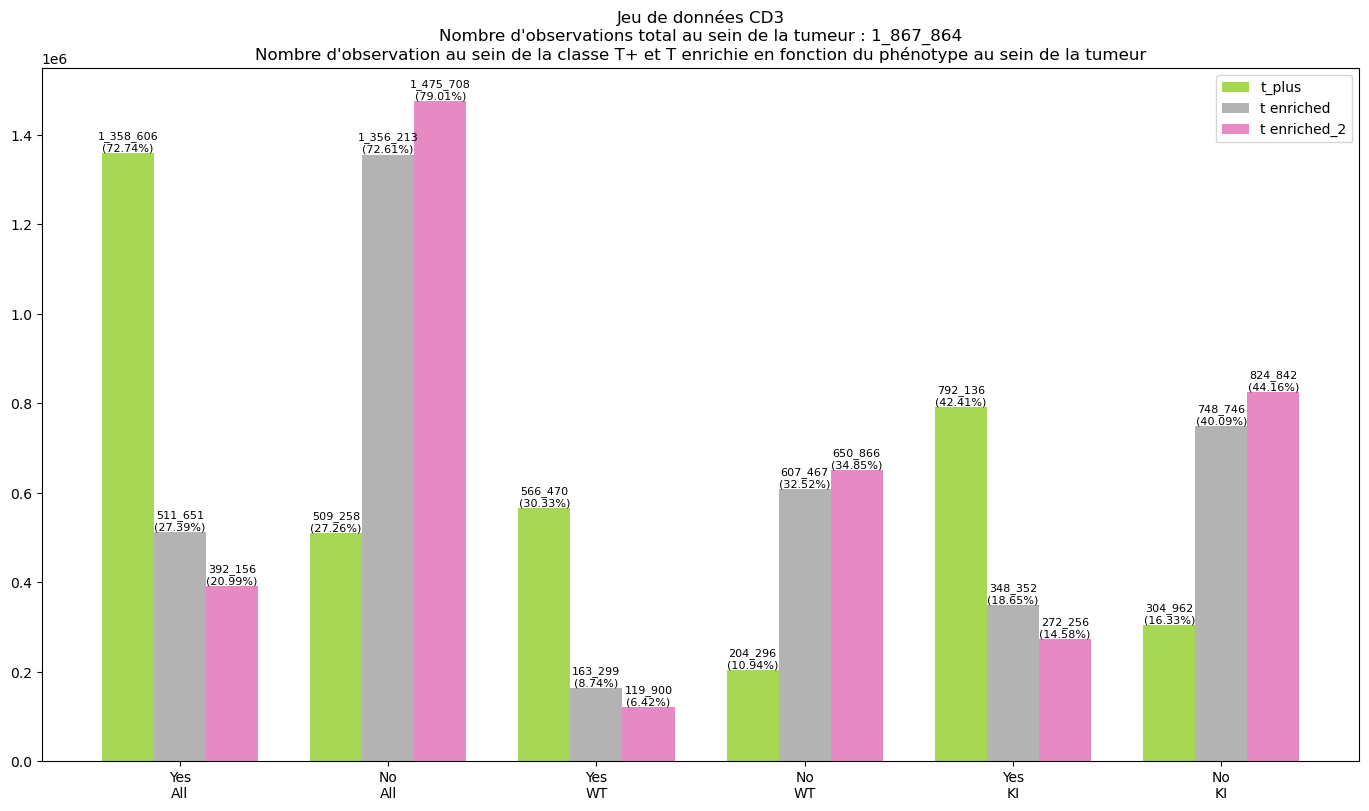

In [26]:
# Observation number in each class
pos, width = np.arange(df_cd3_class_count.shape[0]), 0.25

fig, ax = plt.subplots(figsize=(17, 9))
ax.bar(pos, df_cd3_class_count["count_t_plus"], width=width, label="t_plus", color=color_t_plus)
ax.bar(pos + width, df_cd3_class_count["count_t_enriched"], width=width, label="t enriched", color=color_t_enriched)
ax.bar(pos + width * 2, df_cd3_class_count["count_t_enriched_2"], width=width, label="t enriched_2", color=color_t_enriched_2)
ax.set_title(
    "Jeu de données CD3\n"
    f"Nombre d'observations total au sein de la tumeur : {df_cd3_zones_in.shape[0]:_}\n"
    "Nombre d'observation au sein de la classe T+ et T enrichie en fonction du phénotype au sein de la tumeur"
)
ax.bar_label(ax.containers[0], fontsize=8, fmt=lambda k: f"{k:_.0f}\n({100*k/df_cd3_zones_in.shape[0]:.2f}%)")
ax.bar_label(ax.containers[1], fontsize=8, fmt=lambda k: f"{k:_.0f}\n({100*k/df_cd3_zones_in.shape[0]:.2f}%)")
ax.bar_label(ax.containers[2], fontsize=8, fmt=lambda k: f"{k:_.0f}\n({100*k/df_cd3_zones_in.shape[0]:.2f}%)")
ax.legend()
plt.xticks(pos + width, df_cd3_class_count["class"] + "\n"+df_cd3_class_count["Condition"])
plt.show()

**Au sein de chaque image, quel est le nombre d'observations T+ et T enrichies**

In [27]:
# Number of observations per file
df_cd3_zones_perfile = df_cd3_perfile_in_tumor.copy()

cd3_perfile_t_plus = (
    df_cd3_zones_in.loc[mask_t_plus, ["FileName"]].value_counts()
    .to_frame().rename(columns={"count": "count_t_plus"})
)
cd3_perfile_t_enriched = (
    df_cd3_zones_in.loc[mask_t_enriched, ["FileName"]].value_counts()
    .to_frame().rename(columns={"count": "count_t_enriched"})
)
cd3_perfile_t_enriched_2 = (
    df_cd3_zones_in.loc[mask_t_enriched_2, ["FileName"]].value_counts()
    .to_frame().rename(columns={"count": "count_t_enriched_2"})
)

# Necessary to convert MultiIndex to Index
cd3_perfile_t_plus.index = (cd3_perfile_t_plus.reset_index(level=0)["FileName"])
cd3_perfile_t_enriched.index = (cd3_perfile_t_enriched.reset_index(level=0)["FileName"])
cd3_perfile_t_enriched_2.index = (cd3_perfile_t_enriched_2.reset_index(level=0)["FileName"])
# Join to main frame
df_cd3_zones_perfile = df_cd3_zones_perfile.join(cd3_perfile_t_plus)
df_cd3_zones_perfile = df_cd3_zones_perfile.join(cd3_perfile_t_enriched)
df_cd3_zones_perfile = df_cd3_zones_perfile.join(cd3_perfile_t_enriched_2)

# NaN to 0
df_cd3_zones_perfile[~(df_cd3_zones_perfile == df_cd3_zones_perfile)] = 0  # replace NaN by 0

# Add percent columns
df_cd3_zones_perfile["percent_t_plus"] = df_cd3_zones_perfile["count_t_plus"] / df_cd3_zones_perfile["Nobs"]
df_cd3_zones_perfile["percent_t_enriched"] = df_cd3_zones_perfile["count_t_enriched"] / df_cd3_zones_perfile["Nobs"]
df_cd3_zones_perfile["percent_t_enriched_2"] = df_cd3_zones_perfile["count_t_enriched_2"] / df_cd3_zones_perfile["Nobs"]

df_cd3_zones_perfile = df_cd3_zones_perfile.reindex(
    columns=[
        "Name", "Condition", "Nobs", "DObs",
        "Cells", "percent_Cells", "Cells100um", "percent_Cells100um",
        "count_t_plus", "count_t_enriched", "count_t_enriched_2",
        "percent_t_plus", "percent_t_enriched", "percent_t_enriched_2"
        ]
)
df_cd3_zones_perfile

,Name,Condition,Nobs,DObs,Cells,percent_Cells,Cells100um,percent_Cells100um,count_t_plus,count_t_enriched,count_t_enriched_2,percent_t_plus,percent_t_enriched,percent_t_enriched_2
FileName,,,,,,,,,,,,,,
./MAX_12b_187_CD3eFITC.tif_SHG.tif,MAX_12b_187_CD3eFITC,WT,71965,50517.0,21448.0,0.298034,640002.88,8.893252,61676,27224.0,20820.0,0.857028,0.378295,0.289307
./FWT_507_down_CD3FITC.tif_max.tif_SHG.tif,FWT_507_down_CD3FITC,WT,38647,30264.0,8383.0,0.216912,248582.40,6.432127,30932,10605.0,8086.0,0.800373,0.274407,0.209227
./MAX_12b_189_CD3eFITC.tif_SHG.tif,MAX_12b_189_CD3eFITC,WT,75969,58501.0,17468.0,0.229936,522392.09,6.876385,64343,21514.0,15693.0,0.846964,0.283194,0.206571
./MAX_12b_184_CD3eFITC.tif_SHG.tif,MAX_12b_184_CD3eFITC,WT,62492,45912.0,16580.0,0.265314,496919.17,7.951725,55833,21751.0,15545.0,0.893442,0.348061,0.248752
./MAX_12b_FWT331_CD3_SHG.tif,MAX_12b_FWT331_CD3_SHG,WT,82718,75061.0,7657.0,0.092568,229221.19,2.771116,64235,10390.0,6589.0,0.776554,0.125607,0.079656
./MAX_12b_FWT_333_CD3_SHG.tif,MAX_12b_FWT_333_CD3_SHG,WT,34373,28666.0,5707.0,0.166031,169961.44,4.944620,25631,7473.0,5578.0,0.745672,0.217409,0.162279
./FWT_928_right_CD3FITC.tif_max.tif_SHG.tif,FWT_928_right_CD3FITC,WT,50588,45654.0,4934.0,0.097533,146573.35,2.897394,32443,7399.0,5197.0,0.641318,0.146260,0.102732
./FWT_861_big_CD3FITC.tif_max.tif_SHG.tif,FWT_861_big_CD3FITC,WT,56876,44497.0,12379.0,0.217649,367204.75,6.456234,44141,14551.0,11114.0,0.776092,0.255837,0.195408
./FWT_511_CD3FITC_F480_AF647_Phal546.tif_max.tif_SHG.tif,FWT_511_CD3FITC_F480_AF647_Phal546,WT,34524,24986.0,9538.0,0.276272,282214.35,8.174440,29612,12671.0,9641.0,0.857722,0.367020,0.279255


**Nombre de cellules T au sein des différentes classes**

/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

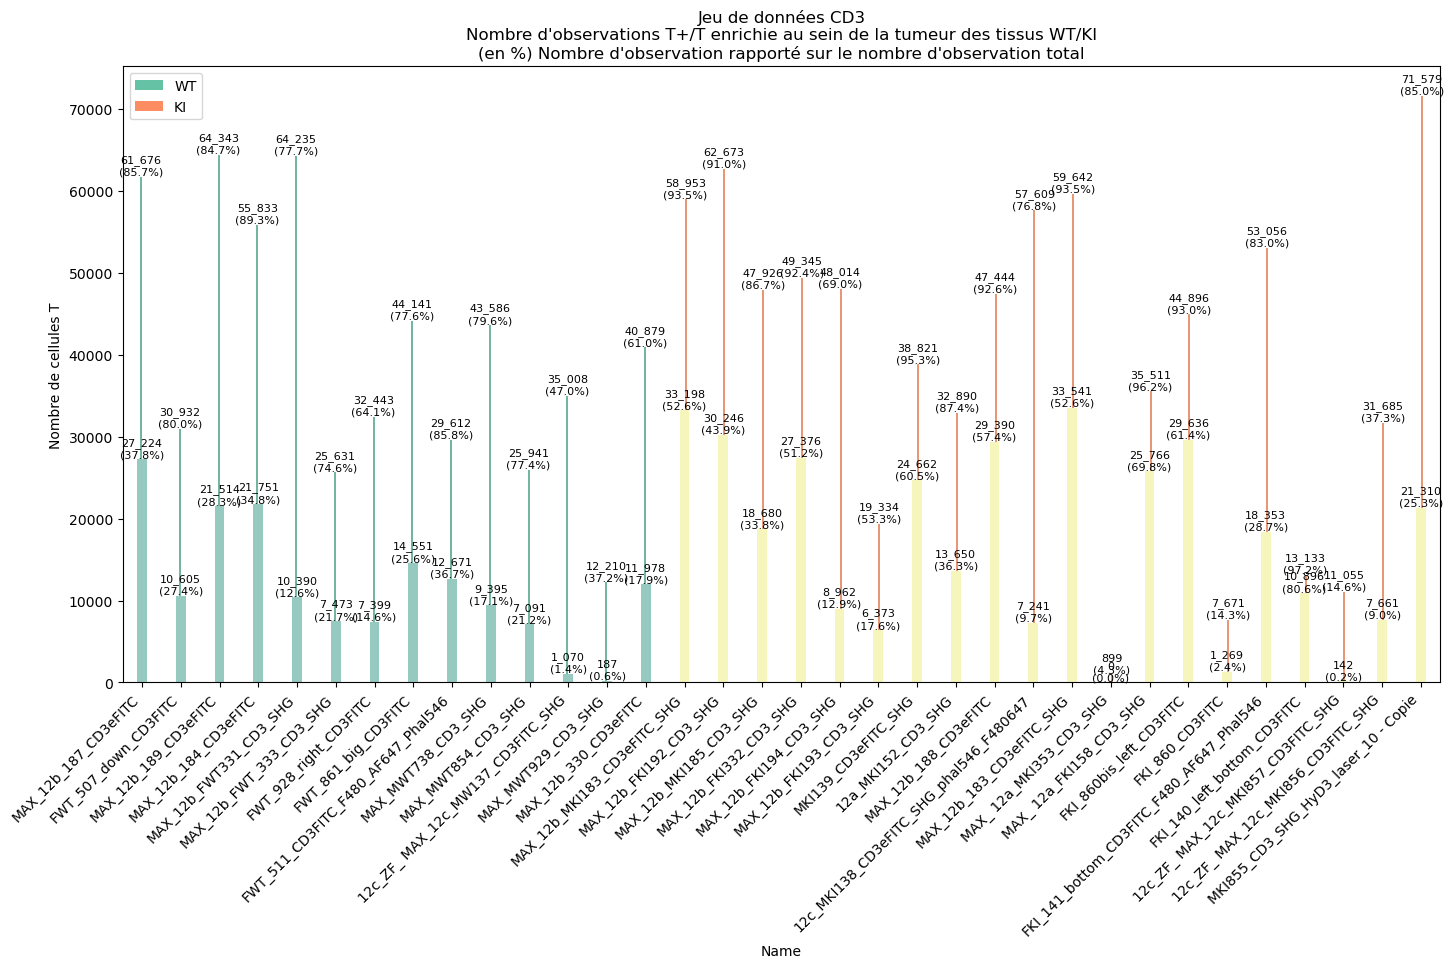

In [28]:
# Number of T Cells per file in each class
fig, ax = plt.subplots(figsize=(17, 8))
sns.barplot(ax=ax, data=df_cd3_zones_perfile, x="Name", y="count_t_plus", hue="Condition", palette = "Set2", width=0.1)
sns.barplot(ax=ax, data=df_cd3_zones_perfile, x="Name", y="count_t_enriched", hue="Condition", palette = "Set3", dodge=False, width=0.25)

labels = [
    [
        f'{v.get_height():_.0f}\n'
        f'({df_cd3_zones_perfile.iloc[idx][col]*100:.1f}%)'\
        for idx, v in enumerate(ax.containers[i])
    ] for i, col in enumerate(["percent_t_plus"]*2 + ["percent_t_enriched"]*2)
]

for idx, lab in enumerate(labels):
    ax.bar_label(ax.containers[idx], labels=lab, fontsize=8)

ax.set_title(
    "Jeu de données CD3\n"
    "Nombre d'observations T+/T enrichie au sein de la tumeur des tissus WT/KI\n"
    "(en %) Nombre d'observation rapporté sur le nombre d'observation total"
)
ax.set_ylabel("Nombre de cellules T")

ax.legend(
    handles=[
        Patch(facecolor=color_wt, label=WT_label),
        Patch(facecolor=color_ki, label=KI_label),
    ]
)

plt.xticks(rotation=45, ha='right')
figs_to_close.append(fig)

#plots.to_pdf("test1", figs_to_close, bbox_inches="tight")  # Save figures
#[plt.close(fig) for fig in figs_to_close]  # Close figures

**Nombre d'observations T+/T enrichie en fonction du nombre de cellules T (Cells)**

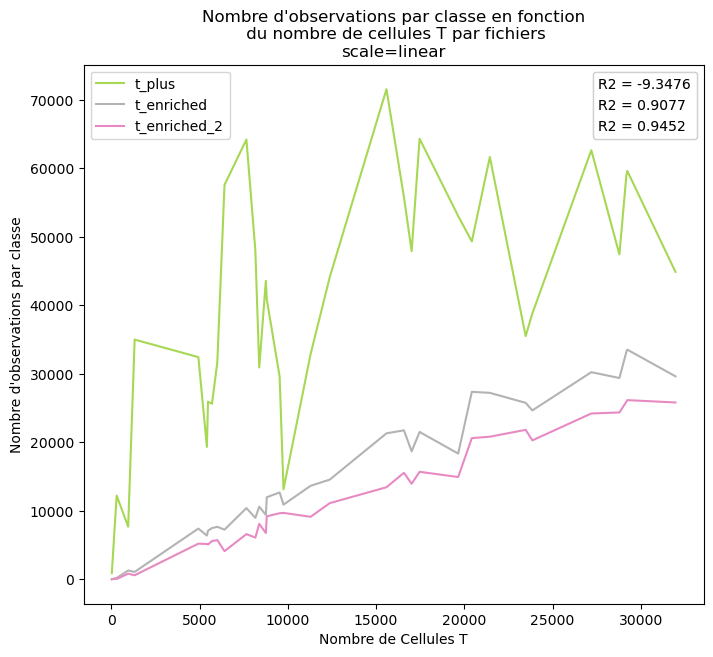

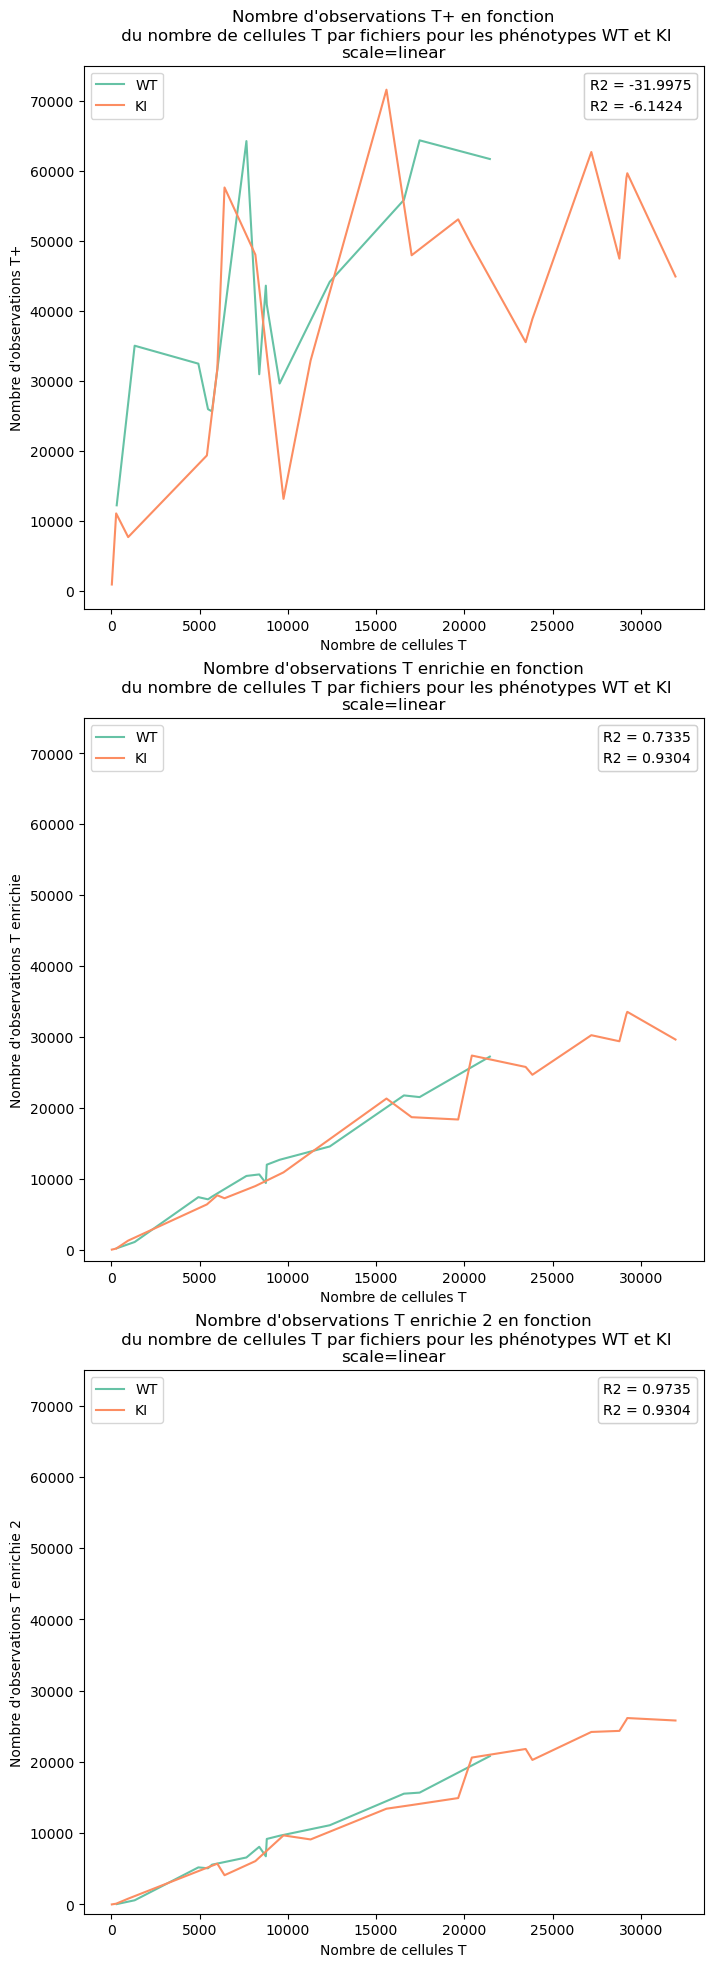

In [69]:
# Evolution of T+/T enriched number with Cells number
fig, ax = plt.subplots(figsize=(8, 7))
col_cells = "Cells"
plots.plot(
    df_cd3_zones_perfile.sort_values(by=[col_cells], ascending=False)["count_t_plus"],
    df_cd3_zones_perfile.sort_values(by=[col_cells], ascending=False)["count_t_enriched"],
    df_cd3_zones_perfile.sort_values(by=[col_cells], ascending=False)["count_t_enriched_2"],
    indices=df_cd3_zones_perfile.sort_values(by=[col_cells], ascending=False)[col_cells],
    title="Nombre d'observations par classe en fonction\n du nombre de cellules T par fichiers",
    xlabel="Nombre de Cellules T", ylabel="Nombre d'observations par classe",
    figure=(fig, ax), color=(color_t_plus, color_t_enriched, color_t_enriched_2),
    label=("t_plus", "t_enriched", "t_enriched_2"), showY=False
)

# Same but while checking WT or KI phenotype
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 24))
# T plus on WT & KI
plots.plot(
    df_cd3_zones_perfile[mask_cd3_perfile_wt_in].sort_values(by=[col_cells], ascending=False)["count_t_plus"],
    df_cd3_zones_perfile[mask_cd3_perfile_ki_in].sort_values(by=[col_cells], ascending=False)["count_t_plus"],
    indices=[
        df_cd3_zones_perfile[mask_cd3_perfile_wt_in].sort_values(by=[col_cells], ascending=False)[col_cells],
        df_cd3_zones_perfile[mask_cd3_perfile_ki_in].sort_values(by=[col_cells], ascending=False)[col_cells],
    ],
    title="Nombre d'observations T+ en fonction\n du nombre de cellules T par fichiers pour les phénotypes WT et KI",
    xlabel="Nombre de cellules T", ylabel="Nombre d'observations T+", ytop=75000,
    figure=(fig, ax1), color=(color_wt, color_ki), label=(WT_label, KI_label), showY=False
)

# T enriched on WT & KI
plots.plot(
    df_cd3_zones_perfile[mask_cd3_perfile_wt_in].sort_values(by=[col_cells], ascending=False)["count_t_enriched"],
    df_cd3_zones_perfile[mask_cd3_perfile_ki_in].sort_values(by=[col_cells], ascending=False)["count_t_enriched"],
    indices=[
        df_cd3_zones_perfile[mask_cd3_perfile_wt_in].sort_values(by=[col_cells], ascending=False)[col_cells],
        df_cd3_zones_perfile[mask_cd3_perfile_ki_in].sort_values(by=[col_cells], ascending=False)[col_cells],
    ],
    title="Nombre d'observations T enrichie en fonction\n du nombre de cellules T par fichiers pour les phénotypes WT et KI",
    xlabel="Nombre de cellules T", ylabel="Nombre d'observations T enrichie", ytop=75000,
    figure=(fig, ax2), color=(color_wt, color_ki), label=(WT_label, KI_label), showY=False
)

# T enriched_2 on WT & KI
plots.plot(
    df_cd3_zones_perfile[mask_cd3_perfile_wt_in].sort_values(by=[col_cells], ascending=False)["count_t_enriched_2"],
    df_cd3_zones_perfile[mask_cd3_perfile_ki_in].sort_values(by=[col_cells], ascending=False)["count_t_enriched_2"],
    indices=[
        df_cd3_zones_perfile[mask_cd3_perfile_wt_in].sort_values(by=[col_cells], ascending=False)[col_cells],
        df_cd3_zones_perfile[mask_cd3_perfile_ki_in].sort_values(by=[col_cells], ascending=False)[col_cells],
    ],
    title="Nombre d'observations T enrichie 2 en fonction\n du nombre de cellules T par fichiers pour les phénotypes WT et KI",
    xlabel="Nombre de cellules T", ylabel="Nombre d'observations T enrichie 2", ytop=75000,
    figure=(fig, ax3), color=(color_wt, color_ki), label=(WT_label, KI_label), showY=False
)

plt.show()

In [61]:
# Table Cells count
table_cd3_zones = df_cd3_zones_in["Cells"].value_counts().to_frame().reset_index(level=0)["Cells"].to_frame()
table_cd3_zones["count_density"] = df_cd3_zones_in[mask_cd3_density_in]["Cells"].value_counts().values
table_cd3_zones["count_density_plus"] = df_cd3_zones_in[mask_cd3_density_in & mask_t_plus]["Cells"].value_counts().values
table_cd3_zones["count_t_enriched"] = df_cd3_zones_in[mask_t_enriched]["Cells"].value_counts().values

table_cd3_zones = table_cd3_zones.join(
    df_cd3_zones_in[mask_t_plus]["Cells"].value_counts().to_frame().rename(columns={"count": "count_t_plus"})
)
table_cd3_zones = table_cd3_zones.join(
    df_cd3_zones_in[~mask_t_plus]["Cells"].value_counts().to_frame().rename(columns={"count": "count_t_negatif"})
)
table_cd3_zones[np.isnan(table_cd3_zones)] = 0
table_cd3_zones

,Cells,count_density,count_density_plus,count_t_enriched,count_t_plus,count_t_negatif
0.0,0.0,539173,392371,259257,1060683,509258.0
1.0,1.0,92695,92695,150391,192988,0.0
2.0,2.0,37977,37977,69863,72666,0.0
3.0,3.0,13333,13333,24957,25082,0.0
4.0,4.0,3219,3219,6131,6135,0.0
5.0,5.0,483,483,941,941,0.0
6.0,6.0,49,49,104,104,0.0
7.0,7.0,3,3,6,6,0.0
8.0,8.0,1,1,1,1,0.0


In [85]:
# Statistics on T cells
q_percent = [0, 0.25, 0.5, 0.75, 1]
col_cells = "Cells"

# Stats on T Cells (WT or KI)
metrics_cells = auxiliary.get_metrics(df_cd3_zones_in[col_cells], q=q_percent)        
cells_mean, cells_std, cells_median, cells_quantile = (
    metrics_cells["mean"], metrics_cells["std"], metrics_cells["median"], metrics_cells["quantile"]
)

# T Cells, Only on WT
metrics_cells_wt = auxiliary.get_metrics(df_cd3_zones_in[mask_cd3_wt_in][col_cells], q=q_percent)        
cells_mean_wt, cells_std_wt, cells_median_wt, cells_quantile_wt = (
    metrics_cells_wt["mean"], metrics_cells_wt["std"], metrics_cells_wt["median"], metrics_cells_wt["quantile"]
)

# T Cells, Only on KI
metrics_cells_ki = auxiliary.get_metrics(df_cd3_zones_in[mask_cd3_ki_in][col_cells], q=q_percent)   
cells_mean_ki, cells_std_ki, cells_median_ki, cells_quantile_ki = (
    metrics_cells_ki["mean"], metrics_cells_ki["std"], metrics_cells_ki["median"], metrics_cells_ki["quantile"]
)

# all & Cells > 0
metrics_cells_sup0 = auxiliary.get_metrics(df_cd3_zones_in[mask_cd3_cells_in][col_cells], q=q_percent)
cells_mean_no0, cells_std_no0, cells_median_no0 ,cells_quantile_no0 = (
    metrics_cells_sup0["mean"], metrics_cells_sup0["std"], metrics_cells_sup0["median"], metrics_cells_sup0["quantile"]
)

# wt & Cells > 0
metrics_cells_sup0_wt = auxiliary.get_metrics(df_cd3_zones_in[mask_cd3_wt_in & mask_cd3_cells_in][col_cells], q=q_percent)
cells_mean_no0_wt, cells_std_no0_wt, cells_median_no0_wt ,cells_quantile_no0_wt = \
    metrics_cells_sup0_wt["mean"], metrics_cells_sup0_wt["std"], metrics_cells_sup0_wt["median"], metrics_cells_sup0_wt["quantile"]

# ki & Cells > 0
metrics_cells_sup0_ki = auxiliary.get_metrics(df_cd3_zones_in[mask_cd3_ki_in & mask_cd3_cells_in][col_cells], q=q_percent)
cells_mean_no0_ki, cells_std_no0_ki, cells_median_no0_ki ,cells_quantile_no0_ki = \
    metrics_cells_sup0_ki["mean"], metrics_cells_sup0_ki["std"], metrics_cells_sup0_ki["median"], metrics_cells_sup0_ki["quantile"]


## Same analysis but with density mask
# Stats on T Cells (WT or KI)
metrics_cells_density = auxiliary.get_metrics(df_cd3_zones_in[mask_cd3_density_in][col_cells], q=q_percent)        
cells_mean_density, cells_std_density, cells_median_density, cells_quantile_density = (
    metrics_cells_density["mean"], metrics_cells_density["std"], metrics_cells_density["median"], metrics_cells_density["quantile"]
)

# T Cells, Density20 > 0 and only on WT
metrics_cells_density_wt = auxiliary.get_metrics(df_cd3_zones_in[mask_cd3_density_in & mask_cd3_wt_in][col_cells], q=q_percent)        
cells_mean_density_wt, cells_std_density_wt, cells_median_density_wt, cells_quantile_density_wt = (
    metrics_cells_density_wt["mean"], metrics_cells_density_wt["std"], metrics_cells_density_wt["median"], metrics_cells_density_wt["quantile"]
)

# T Cells, Density20 > 0 and only on KI
metrics_cells_density_ki = auxiliary.get_metrics(df_cd3_zones_in[mask_cd3_density_in & mask_cd3_ki_in][col_cells], q=q_percent)        
cells_mean_density_ki, cells_std_density_ki, cells_median_density_ki, cells_quantile_density_ki = (
    metrics_cells_density_ki["mean"], metrics_cells_density_ki["std"], metrics_cells_density_ki["median"], metrics_cells_density_ki["quantile"]
)

# density & Cells>0
metrics_cells_density_sup0 = auxiliary.get_metrics(df_cd3_zones_in[mask_cd3_density_in & mask_cd3_cells_in][col_cells], q=q_percent)        
cells_mean_density_no0, cells_std_density_no0, cells_median_density_no0, cells_quantile_density_no0 = (
    metrics_cells_density_sup0["mean"], metrics_cells_density_sup0["std"], metrics_cells_density_sup0["median"], metrics_cells_density_sup0["quantile"]
)

# density & wt & Cells>0
metrics_cells_density_sup0_wt = auxiliary.get_metrics(df_cd3_zones_in[mask_cd3_density_in & mask_cd3_wt_in & mask_cd3_cells_in][col_cells], q=q_percent)        
cells_mean_density_no0_wt, cells_std_density_no0_wt, cells_median_density_no0_wt, cells_quantile_density_no0_wt = (
    metrics_cells_density_sup0_wt["mean"], metrics_cells_density_sup0_wt["std"], metrics_cells_density_sup0_wt["median"], metrics_cells_density_sup0_wt["quantile"]
)

# density & ki & Cells>0
metrics_cells_density_sup0_ki = auxiliary.get_metrics(df_cd3_zones_in[mask_cd3_density_in & mask_cd3_ki_in & mask_cd3_cells_in][col_cells], q=q_percent)        
cells_mean_density_no0_ki, cells_std_density_no0_ki, cells_median_density_no0_ki, cells_quantile_density_no0_ki = (
    metrics_cells_density_sup0_ki["mean"], metrics_cells_density_sup0_ki["std"], metrics_cells_density_sup0_ki["median"], metrics_cells_density_sup0_ki["quantile"]
)

# T Cells
print(
    "----- In tumor -----\n\n"
    f"mean=mean \u00B1 std\n\n"
    f"Stats sur le nombre de cellules T:\n"
    f"(All)\t mean={cells_mean:.2f}\u00B1{cells_std:.2f}{'':4s}median={cells_median:<.2f}\t\n"
    f"(WT)\t mean={cells_mean_wt:.2f}\u00B1{cells_std_wt:.2f}{'':4s}median={cells_median_wt:<10.2f}\t\n"
    f"(KI)\t mean={cells_mean_ki:.2f}\u00B1{cells_std_ki:.2f}{'':4s}median={cells_median_ki:<10.2f}\t\n"
)
print(f"{'Quantile : ':<12s}", end="") ; [print(f"{q*100:>6.2f}{'%':<3s}", end='') for q in q_percent] ; print()
print(f"{'(All)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells_quantile] ; print()
print(f"{'(WT)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells_quantile_wt] ; print()
print(f"{'(KI)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells_quantile_ki] ; print()
print()

print(
    "----- In tumor- Cells > 0 -----\n\n"
    f"Stats sur le nombre de cellules T (avec T>0):\n"
    f"(All)\t mean={cells_mean_no0:.2f}\u00B1{cells_std_no0:.2f}{'':4s}median={cells_median_no0:<10.2f}\t\n"
    f"(WT)\t mean={cells_mean_no0_wt:.2f}\u00B1{cells_std_no0_wt:.2f}{'':4s}median={cells_median_no0_wt:<10.2f}\t\n"
    f"(KI)\t mean={cells_mean_no0_ki:.2f}\u00B1{cells_std_no0_ki:.2f}{'':4s}median={cells_median_no0_ki:<10.2f}\t\n"
)
print(f"{'Quantile : ':<12s}", end="") ; [print(f"{q*100:>6.2f}{'%':<3s}", end='') for q in q_percent] ; print()
print(f"{'(All)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells_quantile_no0] ; print()
print(f"{'(WT)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells_quantile_no0_wt] ; print()
print(f"{'(KI)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells_quantile_no0_ki] ; print()
print()

# T Cells & Density
print(
    "----- In tumor---Density20 > 0 -----\n\n"
    f"Stats sur le nombre de cellules T:\n"
    f"(All)\t mean={cells_mean_density:.2f}\u00B1{cells_std_density:.2f}{'':4s}median={cells_median_density:<10.2f}\t\n"
    f"(WT)\t mean={cells_mean_density_wt:.2f}\u00B1{cells_std_density_wt:.2f}{'':4s}median={cells_median_density_wt:<10.2f}\t\n"
    f"(KI)\t mean={cells_mean_density_ki:.2f}\u00B1{cells_std_density_ki:.2f}{'':4s}median={cells_median_density_ki:<10.2f}\t\n"
)
print(f"{'Quantile : ':<12s}", end="") ; [print(f"{q*100:>6.2f}{'%':<3s}", end='') for q in q_percent] ; print()
print(f"{'(All)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells_quantile_density] ; print()
print(f"{'(WT)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells_quantile_density_wt] ; print()
print(f"{'(KI)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells_quantile_density_ki] ; print()
print()

print(
    "----- In tumor- Cells > 0---Density20 > 0 -----\n\n"
    f"Stats sur le nombre de cellules T (avec T>0):\n"
    f"(All)\t mean={cells_mean_density_no0:.2f}\u00B1{cells_std_density_no0:.2f}{'':4s}median={cells_median_density_no0:<10.2f}\t\n"
    f"(WT)\t mean={cells_mean_density_no0_wt:.2f}\u00B1{cells_std_density_no0_wt:.2f}{'':4s}median={cells_median_density_no0_wt:<10.2f}\t\n"
    f"(KI)\t mean={cells_mean_density_no0_ki:.2f}\u00B1{cells_std_density_no0_ki:.2f}{'':4s}median={cells_median_density_no0_ki:<10.2f}\t\n"
)
print(f"{'Quantile : ':<12s}", end="") ; [print(f"{q*100:>6.2f}{'%':<3s}", end='') for q in q_percent] ; print()
print(f"{'(All)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells_quantile_density_no0] ; print()
print(f"{'(WT)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells_quantile_density_no0_wt] ; print()
print(f"{'(KI)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells_quantile_density_no0_ki] ; print()
print()

# TODO : retrieve p-value
cells_plus_enriched = stats.chi2_contingency(table_cd3_zones[["count_t_plus", "count_t_enriched"]].T)
#cells_plus_enriched

----- In tumor -----

mean=mean ± std

Stats sur le nombre de cellules T:
(All)	 mean=0.24±0.63    median=0.00	
(WT)	 mean=0.17±0.51    median=0.00      	
(KI)	 mean=0.29±0.69    median=0.00      	

Quantile :    0.00%   25.00%   50.00%   75.00%  100.00%  
(All)         0.00     0.00     0.00     0.00     8.00   
(WT)          0.00     0.00     0.00     0.00     6.00   
(KI)          0.00     0.00     0.00     0.00     8.00   

----- In tumor- Cells > 0 -----

Stats sur le nombre de cellules T (avec T>0):
(All)	 mean=1.49±0.77    median=1.00      	
(WT)	 mean=1.39±0.69    median=1.00      	
(KI)	 mean=1.53±0.80    median=1.00      	

Quantile :    0.00%   25.00%   50.00%   75.00%  100.00%  
(All)         1.00     1.00     1.00     2.00     8.00   
(WT)          1.00     1.00     1.00     2.00     6.00   
(KI)          1.00     1.00     1.00     2.00     8.00   

----- In tumor---Density20 > 0 -----

Stats sur le nombre de cellules T:
(All)	 mean=0.33±0.72    median=0.00      	
(WT)	 me

**Nombre d'observations T+/T enrichie en fonction du nombre de cellules T à 100um (Cells100um)**

In [ ]:
# Evolution of T+/T enriched number with Cells100um number
fig, ax = plt.subplots(figsize=(8, 7))
col_cells = "Cells100um"
plots.plot(
    df_cd3_zones_perfile.sort_values(by=[col_cells], ascending=False)["count_t_plus"],
    df_cd3_zones_perfile.sort_values(by=[col_cells], ascending=False)["count_t_enriched"],
    df_cd3_zones_perfile.sort_values(by=[col_cells], ascending=False)["count_t_enriched_2"],
    indices=df_cd3_zones_perfile.sort_values(by=[col_cells], ascending=False)[col_cells],
    title="Nombre d'observations par classe en fonction\n du nombre de Cellules à 100um par fichiers",
    xlabel="Nombre de Cellules à 100um", ylabel="Nombre d'observations par classe",
    figure=(fig, ax), color=(color_t_plus, color_t_enriched, color_t_enriched_2),
    label=("t_plus", "t_enriched", "t_enriched_2"), showY=False
)

# Same but while checking WT or KI phenotype
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 24))
# T plus on WT & KI
plots.plot(
    df_cd3_zones_perfile[mask_cd3_perfile_wt_in].sort_values(by=[col_cells], ascending=False)["count_t_plus"],
    df_cd3_zones_perfile[mask_cd3_perfile_ki_in].sort_values(by=[col_cells], ascending=False)["count_t_plus"],
    indices=[
        df_cd3_zones_perfile[mask_cd3_perfile_wt_in].sort_values(by=[col_cells], ascending=False)[col_cells],
        df_cd3_zones_perfile[mask_cd3_perfile_ki_in].sort_values(by=[col_cells], ascending=False)[col_cells],
    ],
    title="Nombre d'observations T+ en fonction\n du nombre de Cellules à 100um par fichiers pour les phénotypes WT et KI",
    xlabel="Nombre de Cellules à 100um", ylabel="Nombre d'observations T+", ytop=75000,
    figure=(fig, ax1), color=(color_wt, color_ki), label=(WT_label, KI_label), showY=False
)

# T enriched on WT & KI
plots.plot(
    df_cd3_zones_perfile[mask_cd3_perfile_wt_in].sort_values(by=[col_cells], ascending=False)["count_t_enriched"],
    df_cd3_zones_perfile[mask_cd3_perfile_ki_in].sort_values(by=[col_cells], ascending=False)["count_t_enriched"],
    indices=[
        df_cd3_zones_perfile[mask_cd3_perfile_wt_in].sort_values(by=[col_cells], ascending=False)[col_cells],
        df_cd3_zones_perfile[mask_cd3_perfile_ki_in].sort_values(by=[col_cells], ascending=False)[col_cells],
    ],
    title="Nombre d'observations T enrichie en fonction\n du nombre de Cellules à 100um par fichiers pour les phénotypes WT et KI",
    xlabel="Nombre de Cellules à 100um", ylabel="Nombre d'observations T enrichie", ytop=75000,
    figure=(fig, ax2), color=(color_wt, color_ki), label=(WT_label, KI_label), showY=False
)

# T enriched_2 on WT & KI
plots.plot(
    df_cd3_zones_perfile[mask_cd3_perfile_wt_in].sort_values(by=[col_cells], ascending=False)["count_t_enriched_2"],
    df_cd3_zones_perfile[mask_cd3_perfile_ki_in].sort_values(by=[col_cells], ascending=False)["count_t_enriched_2"],
    indices=[
        df_cd3_zones_perfile[mask_cd3_perfile_wt_in].sort_values(by=[col_cells], ascending=False)[col_cells],
        df_cd3_zones_perfile[mask_cd3_perfile_ki_in].sort_values(by=[col_cells], ascending=False)[col_cells],
    ],
    title="Nombre d'observations T enrichie 2 en fonction\n du nombre de Cellules à 100um par fichiers pour les phénotypes WT et KI",
    xlabel="Nombre de Cellules à 100um", ylabel="Nombre d'observations T enrichie 2", ytop=75000,
    figure=(fig, ax3), color=(color_wt, color_ki), label=(WT_label, KI_label), showY=False
)

plt.show()

In [72]:
# Table Cells100um count (only total count per class)
col_cells = "Cells100um"
table_cd3_zones_cells100um = pd.merge(
    df_cd3_zones_in[col_cells].value_counts().to_frame().reset_index(level=0)[col_cells].to_frame(),
    df_cd3_zones_in[mask_cd3_density_in][col_cells].value_counts().to_frame().reset_index(level=0),
    on=col_cells, how="left"
).rename(columns={"count": "count_density"})

table_cd3_zones_cells100um = pd.merge(
    table_cd3_zones_cells100um,
    df_cd3_zones_in[mask_cd3_density_in & mask_t_plus][col_cells].value_counts().to_frame().reset_index(level=0),
    on=col_cells, how="left"
).rename(columns={"count": "count_density_plus"})

table_cd3_zones_cells100um = pd.merge(
    table_cd3_zones_cells100um,
    df_cd3_zones_in[mask_t_enriched][col_cells].value_counts().to_frame().reset_index(level=0),
    on=col_cells, how="left"
).rename(columns={"count": "count_t_enriched"})

table_cd3_zones_cells100um = pd.merge(
    table_cd3_zones_cells100um,
    df_cd3_zones_in[mask_t_plus][col_cells].value_counts().to_frame().reset_index(level=0),
    on=col_cells, how="left"
).rename(columns={"count": "count_t_plus"})

table_cd3_zones_cells100um = pd.merge(
    table_cd3_zones_cells100um,
    df_cd3_zones_in[~mask_t_plus][col_cells].value_counts().to_frame().reset_index(level=0),
    on=col_cells, how="left"
).rename(columns={"count": "count_t_negatif"})

table_cd3_zones_cells100um[np.isnan(table_cd3_zones_cells100um)] = 0
table_cd3_zones_cells100um.sum(axis=0).to_frame().T  # Nombre de Cells100um par classe

,Cells100um,count_density,count_density_plus,count_t_enriched,count_t_plus,count_t_negatif
0,50556.22,686933.0,540131.0,511651.0,1358606.0,509258.0


In [88]:
# Statistics on Cells number at 100um from a position
q_percent = [0, 0.25, 0.5, 0.75, 1] 
col_cells = "Cells100um"

## all
cells100um = auxiliary.get_metrics(df_cd3_zones_in[col_cells], q=q_percent)        
cells100um_mean, cells100um_std, cells100um_median, cells100um_quantile = \
    cells100um["mean"], cells100um["std"], cells100um["median"], cells100um["quantile"]

# wt
cells100um_wt = auxiliary.get_metrics(df_cd3_zones_in[mask_cd3_wt_in][col_cells], q=q_percent)        
cells100um_mean_wt, cells100um_std_wt, cells100um_median_wt, cells100um_quantile_wt = \
    cells100um_wt["mean"], cells100um_wt["std"], cells100um_wt["median"], cells100um_wt["quantile"]

# ki
cells100um_ki = auxiliary.get_metrics(df_cd3_zones_in[mask_cd3_ki_in][col_cells], q=q_percent)   
cells100um_mean_ki, cells100um_std_ki, cells100um_median_ki, cells100um_quantile_ki = \
    cells100um_ki["mean"], cells100um_ki["std"], cells100um_ki["median"], cells100um_ki["quantile"]

# all & Cells100um > 0
cells100um_no0 = auxiliary.get_metrics(df_cd3_zones_in[mask_cd3_cells100um_in][col_cells], q=q_percent)
cells100um_mean_no0, cells100um_std_no0, cells100um_median_no0 ,cells100um_quantile_no0 = \
    cells100um_no0["mean"], cells100um_no0["std"], cells100um_no0["median"], cells100um_no0["quantile"]

# wt & Cells100um > 0
cells100um_no0_wt = auxiliary.get_metrics(df_cd3_zones_in[mask_cd3_wt_in & mask_cd3_cells100um_in][col_cells], q=q_percent)
cells100um_mean_no0_wt, cells100um_std_no0_wt, cells100um_median_no0_wt ,cells100um_quantile_no0_wt = \
    cells100um_no0_wt["mean"], cells100um_no0_wt["std"], cells100um_no0_wt["median"], cells100um_no0_wt["quantile"]

# ki & Cells100um > 0
cells100um_no0_ki = auxiliary.get_metrics(df_cd3_zones_in[mask_cd3_ki_in & mask_cd3_cells100um_in][col_cells], q=q_percent)
cells100um_mean_no0_ki, cells100um_std_no0_ki, cells100um_median_no0_ki ,cells100um_quantile_no0_ki = \
    cells100um_no0_ki["mean"], cells100um_no0_ki["std"], cells100um_no0_ki["median"], cells100um_no0_ki["quantile"]

## density
cells100um_density = auxiliary.get_metrics(df_cd3_zones_in[mask_cd3_density_in][col_cells], q=q_percent)        
cells100um_mean_density, cells100um_std_density, cells100um_median_density, cells100um_quantile_density = \
    cells100um_density["mean"], cells100um_density["std"], cells100um_density["median"], cells100um_density["quantile"]

# density & wt
cells100um_density_wt = auxiliary.get_metrics(df_cd3_zones_in[mask_cd3_density_in & mask_cd3_wt_in][col_cells], q=q_percent)        
cells100um_mean_density_wt, cells100um_std_density_wt, cells100um_median_density_wt, cells100um_quantile_density_wt = \
    cells100um_density_wt["mean"], cells100um_density_wt["std"], cells100um_density_wt["median"], cells100um_density_wt["quantile"]

# density & ki
cells100um_density_ki = auxiliary.get_metrics(df_cd3_zones_in[mask_cd3_density_in & mask_cd3_ki_in][col_cells], q=q_percent)        
cells100um_mean_density_ki, cells100um_std_density_ki, cells100um_median_density_ki, cells100um_quantile_density_ki = \
    cells100um_density_ki["mean"], cells100um_density_ki["std"], cells100um_density_ki["median"], cells100um_density_ki["quantile"]

# density & Cells100um>0
cells100um_density_no0 = auxiliary.get_metrics(df_cd3_zones_in[mask_cd3_density_in & mask_cd3_cells100um_in][col_cells], q=q_percent)        
cells100um_mean_density_no0, cells100um_std_density_no0, cells100um_median_density_no0, cells100um_quantile_density_no0 = \
    cells100um_density_no0["mean"], cells100um_density_no0["std"], cells100um_density_no0["median"], cells100um_density_no0["quantile"]

# density & wt & Cells100um>0
cells100um_density_no0_wt = auxiliary.get_metrics(df_cd3_zones_in[mask_cd3_density_in & mask_cd3_wt_in & mask_cd3_cells100um_in][col_cells], q=q_percent)        
cells100um_mean_density_no0_wt, cells100um_std_density_no0_wt, cells100um_median_density_no0_wt, cells100um_quantile_density_no0_wt = \
    cells100um_density_no0_wt["mean"], cells100um_density_no0_wt["std"], cells100um_density_no0_wt["median"], cells100um_density_no0_wt["quantile"]

# density & ki & Cells100um>0
cells100um_density_no0_ki = auxiliary.get_metrics(df_cd3_zones_in[mask_cd3_density_in & mask_cd3_ki_in & mask_cd3_cells100um_in][col_cells], q=q_percent)        
cells100um_mean_density_no0_ki, cells100um_std_density_no0_ki, cells100um_median_density_no0_ki, cells100um_quantile_density_no0_ki = \
    cells100um_density_no0_ki["mean"], cells100um_density_no0_ki["std"], cells100um_density_no0_ki["median"], cells100um_density_no0_ki["quantile"]

# T Cells
print(
    "----- In tumor -----\n\n"
    f"mean=mean \u00B1 std\n\n"
    f"Stats sur le nombre de cellules à 100um :\n"
    f"(All)\t mean={cells100um_mean:.2f}\u00B1{cells100um_std:.2f}{'':4s}median={cells100um_median:<.2f}\t\n"
    f"(WT)\t mean={cells100um_mean_wt:.2f}\u00B1{cells100um_std_wt:.2f}{'':4s}median={cells100um_median_wt:<10.2f}\t\n"
    f"(KI)\t mean={cells100um_mean_ki:.2f}\u00B1{cells100um_std_ki:.2f}{'':4s}median={cells100um_median_ki:<10.2f}\t\n"
)
print(f"{'Quantile : ':<12s}", end="") ; [print(f"{q*100:>6.2f}{'%':<3s}", end='') for q in q_percent] ; print()
print(f"{'(All)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells100um_quantile] ; print()
print(f"{'(WT)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells100um_quantile_wt] ; print()
print(f"{'(KI)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells100um_quantile_ki] ; print()
print()

print(
    "----- In tumor- Cells100um > 0 -----\n\n"
    f"Stats sur le nombre de cellules à 100um (avec T>0):\n"
    f"(All)\t mean={cells100um_mean_no0:.2f}\u00B1{cells100um_std_no0:.2f}{'':4s}median={cells100um_median_no0:<10.2f}\t\n"
    f"(WT)\t mean={cells100um_mean_no0_wt:.2f}\u00B1{cells100um_std_no0_wt:.2f}{'':4s}median={cells100um_median_no0_wt:<10.2f}\t\n"
    f"(KI)\t mean={cells100um_mean_no0_ki:.2f}\u00B1{cells100um_std_no0_ki:.2f}{'':4s}median={cells100um_median_no0_ki:<10.2f}\t\n"
)
print(f"{'Quantile : ':<12s}", end="") ; [print(f"{q*100:>6.2f}{'%':<3s}", end='') for q in q_percent] ; print()
print(f"{'(All)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells100um_quantile_no0] ; print()
print(f"{'(WT)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells100um_quantile_no0_wt] ; print()
print(f"{'(KI)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells100um_quantile_no0_ki] ; print()
print()

# T Cells & Density
print(
    "----- In tumor---Density20 > 0 -----\n\n"
    f"Stats sur le nombre de cellules à 100um T:\n"
    f"(All)\t mean={cells100um_mean_density:.2f}\u00B1{cells100um_std_density:.2f}{'':4s}median={cells100um_median_density:<10.2f}\t\n"
    f"(WT)\t mean={cells100um_mean_density_wt:.2f}\u00B1{cells100um_std_density_wt:.2f}{'':4s}median={cells100um_median_density_wt:<10.2f}\t\n"
    f"(KI)\t mean={cells100um_mean_density_ki:.2f}\u00B1{cells100um_std_density_ki:.2f}{'':4s}median={cells100um_median_density_ki:<10.2f}\t\n"
)
print(f"{'Quantile : ':<12s}", end="") ; [print(f"{q*100:>6.2f}{'%':<3s}", end='') for q in q_percent] ; print()
print(f"{'(All)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells100um_quantile_density] ; print()
print(f"{'(WT)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells100um_quantile_density_wt] ; print()
print(f"{'(KI)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells100um_quantile_density_ki] ; print()
print()

print(
    "----- In tumor- Cells100um > 0---Density20 > 0 -----\n\n"
    f"Stats sur le nombre de cellules à 100um (avec T>0):\n"
    f"(All)\t mean={cells100um_mean_density_no0:.2f}\u00B1{cells100um_std_density_no0:.2f}{'':4s}median={cells100um_median_density_no0:<10.2f}\t\n"
    f"(WT)\t mean={cells100um_mean_density_no0_wt:.2f}\u00B1{cells100um_std_density_no0_wt:.2f}{'':4s}median={cells100um_median_density_no0_wt:<10.2f}\t\n"
    f"(KI)\t mean={cells100um_mean_density_no0_ki:.2f}\u00B1{cells100um_std_density_no0_ki:.2f}{'':4s}median={cells100um_median_density_no0_ki:<10.2f}\t\n"
)
print(f"{'Quantile : ':<12s}", end="") ; [print(f"{q*100:>6.2f}{'%':<3s}", end='') for q in q_percent] ; print()
print(f"{'(All)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells100um_quantile_density_no0] ; print()
print(f"{'(WT)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells100um_quantile_density_no0_wt] ; print()
print(f"{'(KI)':<12s}", end="") ; [print(f"{t:>6.2f}{'':<3s}", end='') for t in cells100um_quantile_density_no0_ki] ; print()
print()

# TODO : retrieve p-value
cells100um_plus_enriched = stats.chi2_contingency(table_cd3_zones[["count_t_plus", "count_t_enriched"]].T)
#cells100um_plus_enriched

----- In tumor -----

mean=mean ± std

Stats sur le nombre de cellules à 100um :
(All)	 mean=7.08±12.60    median=1.21	
(WT)	 mean=4.97±9.53    median=1.21      	
(KI)	 mean=8.56±14.18    median=2.42      	

Quantile :    0.00%   25.00%   50.00%   75.00%  100.00%  
(All)        -0.00     0.00     1.21     7.26   101.64   
(WT)         -0.00     0.00     1.21     4.84   101.64   
(KI)         -0.00     0.00     2.42     9.68   101.64   

----- In tumor- Cells100um > 0 -----

Stats sur le nombre de cellules à 100um (avec T>0):
(All)	 mean=9.73±13.87    median=3.63      	
(WT)	 mean=6.76±10.56    median=2.42      	
(KI)	 mean=11.86±15.47    median=4.84      	

Quantile :    0.00%   25.00%   50.00%   75.00%  100.00%  
(All)         0.00     1.21     3.63    12.10   101.64   
(WT)          0.00     0.00     2.42     8.47   101.64   
(KI)          0.00     1.21     4.84    15.73   101.64   

----- In tumor---Density20 > 0 -----

Stats sur le nombre de cellules à 100um T:
(All)	 mean=9.62±14.

In [100]:
def plot(
    *values, indices=None, scale="linear", mode="plot",
    title="", xlabel="", ylabel="", label=("",), alphas=(1,),
    xleft=None, xright=None, ytop=None, ybottom=None, normalize=False,
    figure=None, figsize=None, anchor_x=1.05, anchor_y=0.9,
    color=None, color_palette="Set1", showY=True, showR2=True,
    save_to=None, filename="plot", ext="png", forcename=False, overwrite=True,
    ignore_nan=True, **kwargs
):
    """Generate a specified figure from a set of values.

    values: list -> list(Array-like)
        Values to plot, correspond to y axis

    indices: list -> list(Array-like)
        Values in x axis

    scale: str, default="linear"
        Chosen scale for observed and predicted values
        "linear", "log", ...

    mode: str, default="plot"
        Selected mode for plot taking values such as 
        "plot" -> line plot
        "bar" -> barplot plot
        "hist" -> histogram plot
        "scatter" -> scatter plot
        "violin" -> violin plot

    title, xlabel, ylabel: str
        Title, x-axis and y-axis labels to assign to
        the figure

    label: list -> list(str)
        Associated label to the plot (for legend purpose).

    alphas: tuple(float), optional
        alpha values for the plot

    xleft, xright: float, optional
        lower and upper x limit

    ybottom, ytop: int, optional
        lower and upper y limit

    normalize: bool
        Normalize values so that it is bound to [0; 1]

    figure: matplotlib.figure.Figure -> (fig, ax)
        A tuple corresponding to a Figure returned by
        matplotlib.figure.figure, the axis {ax} should
        correspond to only one

    figsize: tuple -> tuple(float, float), optional
        Width and height in inches.

    anchor_x, anchor_y: float, float
        Box legend position visible with {showY} and {showR2}

    color: tuple, optional
        Associated color for each {values} plots

    color_palette: matplotlib.colors.ListedColormap
        Associated palette to the plot. Is used when
        each {values} does not have an attributed color.

    showY: bool
        show legend parameters associated with the metric

    showR2: bool
        show R2 values for each {values}

    save_to: str
        Directory to save plot to

    filename: str
        Name of the file to create

    ext: str
        Extension of the file to create

    forcename: bool
        If True, then filename will exactly be the same
        as specified and only the extension will be appended.
        Else, extension is replaced by detecting the last "."
        character to replace it.

    overwrite: str
        If a plot have the same name as our, should we
        overwrite ? If not, it creates a filename with
        an appended suffix

    ignore_nan: bool
        Should we ignore nan value ? When plotting,
        and calculating metrics such as mean, median
        and std    

    Returns: tuple (matplotlib.figure, matplotlib.axes.Axes)
        Figure and Axes for graphical purposes

    """
    # Number of observations to plot
    n_obs = len(values)
    # Color palette
    palette = sns.color_palette(color_palette)
    # Figure size
    figsize = (8, 7) if figsize is None else figsize

    # Plot mode selection
    plotting_mode = {
        "plot": lambda ax: ax.plot,
        "bar": lambda ax: ax.bar,
        "hist": lambda ax: ax.hist,
        "scatter": lambda ax: ax.scatter,
        "violin": lambda ax: ax.violinplot
    }

    # Check mode
    if mode not in plotting_mode.keys():
        raise Exception("Selected mode is invalid")

    if n_obs == 0:
        raise Exception(
            "At least one argument should be provided for {values}"
        )

    # Check if each {*values} provided is of instance np.ndarray
    # converts them if possible.
    values_length = []
    values_list = list(values)
    for idx, val in enumerate(values):
        if not isinstance(val, np.ndarray):
            try:
                val_np = np.array(val)
                values_list[idx] = val_np if not normalize else \
                                   auxiliary.min_max_normalization(
                                       val_np, 0, 1, ignore_nan=ignore_nan
                                   )
            except:
                raise Exception(
                    "Array-like values should be "
                    "provided for {values} argument"
                )
        values_length.append(len(val))

    values = tuple(values_list)

    # x-axis equals indices if not set
    if indices is None:
        indices = [np.arange(length) for length in values_length]
    elif all(isinstance(ind, (int, float)) for ind in indices):
        indices = [indices]
    for idx, ind in enumerate(indices):
        if not isinstance(ind, np.ndarray):
            try:
                indices[idx] = np.array(ind)
            except:
                raise Exception(
                    "Could not convert data to "
                    "numpy.ndarray, check {indices} "
                    "argument."
                )

    if (len(indices) == 1) & (n_obs > len(indices)):
        if len(indices[0]) < max(values_length):
            raise Exception("indices should be set for each ticks position")

        indices_per_val = []
        for idx in range(n_obs):
            indices_per_val.append(indices[0][:len(values[idx])])
        indices = indices_per_val

    # alpha value for each {*values}
    alphas = (1,) if alphas is None else alphas
    alphas = (alphas, ) if isinstance(alphas, (int, float)) else tuple(alphas)
    alphas = alphas + (1,) * (n_obs-len(alphas)) if len(alphas) < n_obs else alphas

    # color value for each {*values}
    color = ("#1f77b4",) if color is None else color
    if len(color) < n_obs:
        color_tmp = []
        for idx in range(n_obs - len(color)):
            color_tmp.append(palette[idx%len(palette)])
        color = color + tuple(color_tmp)

    label = ("", ) if label is None else label
    label = (label, ) if isinstance(label, (str)) else tuple(label)
    label = label + ("",) * (n_obs-len(label)) if len(label) < n_obs else label

    ## Optional arguments
    # Bins
    if mode.startswith("hist"):
        kwargs["bins"] = kwargs.get("bins", (100,))
        if isinstance(kwargs["bins"], (float, int)):
            kwargs["bins_list"] = (kwargs["bins"],)
        else:
            kwargs["bins_list"] = tuple(kwargs.bins["bins"])

        if len(kwargs["bins_list"]) < n_obs:
            kwargs["bins_list"] = kwargs["bins_list"] + (100, ) * (n_obs - len(kwargs["bins_list"]))

    if mode == "bar":
        kwargs["width"] = kwargs.get("width", 0.8)
        kwargs["dodge"] = kwargs.get("dodge", False)
        dodge = kwargs.pop("dodge")

    xticks = kwargs.pop("xticks") if kwargs.get("xticks", None) else None
    yticks = kwargs.pop("yticks") if kwargs.get("yticks", None) else None
    grid = kwargs.pop("grid") if kwargs.get("grid", False) else False

    # Plot depending on mode
    fig, ax = plt.subplots(figsize=figsize) if figure is None else figure
    _vl_label_list = []
    for idx, val in enumerate(values):
        if (mode == "plot"):
            plotting_mode[mode](ax)(indices[idx], val, label=label[idx], alpha=alphas[idx], color=color[idx], **kwargs)
        elif (mode == "hist"):
            plotting_mode[mode](ax)(val, bins=kwargs["bins_list"][idx], label=label[idx], color=color[idx], alpha=alphas[idx])
        elif (mode == "bar"):
            if dodge:  # When there is multiple bar, shift them
                plotting_mode[mode](ax)(indices[idx] + idx*kwargs["width"], val, label=label[idx], alpha=alphas[idx], color=color[idx], **kwargs)
            else:
                plotting_mode[mode](ax)(indices[idx], val, label=label[idx], alpha=alphas[idx], color=color[idx], **kwargs)
        elif (mode == "violin"):
            vl = plotting_mode[mode](ax)(val, positions=[idx], **kwargs)
            vl_label = [mpatches.Patch(color=vl["bodies"][0].get_facecolor().flatten()), label]
            _vl_label_list.append(vl_label)
            if idx == n_obs - 1:
                main_legend = ax.legend(*zip(*_vl_label_list), loc=2)
                ax.add_artist(main_legend)
        elif (mode == "scatter"):
            plotting_mode[mode](ax)(indices[idx], val, label=label[idx], alpha=alphas[idx], color=color[idx], **kwargs)

    # Main Legend
    if True:
        handles, labels = ax.get_legend_handles_labels()
        if (handles != []) & (labels != []):
            main_legend = ax.legend(handles, labels, loc="upper left")
            ax.add_artist(main_legend)

        if showY:
            anchor_y_cumul = anchor_y
            for idx, val in enumerate(values):
                handles_y, labels_y = [], []
                
                # Observed and Predicted : Mean, std, median
                mean_yvalues = val.mean() if not ignore_nan else np.nanmean(val)
                std_yvalues = val.std() if not ignore_nan else np.nanstd(val)
                median_yvalues = np.median(val) if not ignore_nan else np.nanmedian(val)
        
                mean_yvalues_label, mean_yvalues_patch = legend_patch(f"mean = {mean_yvalues:.3f}")
                std_yvalues_label, std_yvalues_patch = legend_patch(f"std = {std_yvalues:.3f}")
                median_yvalues_label, median_yvalues_patch = legend_patch(f"median = {median_yvalues:.3f}")
    
                handles_y.extend([mean_yvalues_patch, std_yvalues_patch, median_yvalues_patch])
                labels_y.extend([mean_yvalues_label, std_yvalues_label, median_yvalues_label])
    
                msm_observed_legend = ax.legend(
                    handles_y, labels_y, title=label[idx], loc="center",
                    handlelength=0, handletextpad=0, borderaxespad=0,
                    bbox_to_anchor=(anchor_x, anchor_y_cumul)
                )
                anchor_y_cumul -= 0.14 if label == ("", ) else 0.17
                ax.add_artist(msm_observed_legend)  # Add legend to artist

        if showR2:  # R2
            handles_r2, labels_r2 = [], []
            for idx, val in enumerate(values):
                isnotnan = ~np.isnan(val)  # index of not NaN values
    
                r2 = r2_score(indices[idx][isnotnan], val[isnotnan])
                r2_label, r2_patch = legend_patch(f"R2 = {r2:.4f}")
                handles_r2.append(r2_patch)
                labels_r2.append(r2_label)

            r2_legend = ax.legend(
                handles_r2, labels_r2, loc="upper right",
                handlelength=0, handletextpad=0
            )

            # Add legend
            ax.add_artist(r2_legend)

    # Set scale selected by user
    ax.set_xscale(scale)
    ax.set_yscale(scale)
    # Option for specific mode
    if (mode == "scatter"):
        # Range to have xlim=ylim
        xy_lim = auxiliary.min_max(ax.get_xlim() + ax.get_ylim())
        ax.set_xlim(xy_lim)
        ax.set_ylim(xy_lim)

    # Set figure label, limit and legend
    if xticks is not None:
        ax.set_xticks(xticks)
    if yticks is not None:
        ax.set_yticks(yticks)

    # Label
    title = title if title == "" else f"{title}\nscale={scale}"
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # Limit in x and y
    ax.set_xlim(left=xleft, right=xright)
    ax.set_ylim(top=ytop, bottom=ybottom)
    # Grid
    ax.grid(grid)

    # Save plot if {save_to} is specified
    if save_to is not None:
        if not auxiliary.isdir(save_to):
            raise Exception("Specified directory does not exists")

        ext = ext.replace(".", "")
        save_to = auxiliary.to_dirpath(save_to)
        filepath = save_to + filename + "." + ext
        if not forcename:
            root, _ = os.path.splitext(filename)
            # Save file to
            filename = auxiliary.replace_extension(root, ext)
            filepath = save_to + filename if overwrite else \
                       auxiliary.filepath_with_suffix(save_to + filename)

        plt.savefig(filepath, bbox_inches = 'tight')

    return fig, ax

[1, 2, 3, 4, 5]


NameError: name 'legend_patch' is not defined

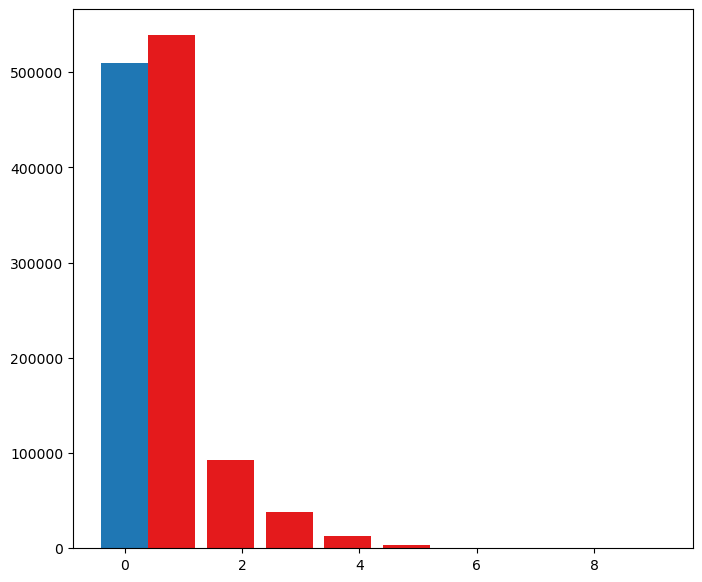

In [101]:
plot(
    table_cd3_zones["count_t_negatif"],
    table_cd3_zones["count_density"],
    xticks=[1, 2, 3, 4, 5],
    mode="bar", dodge=True
)

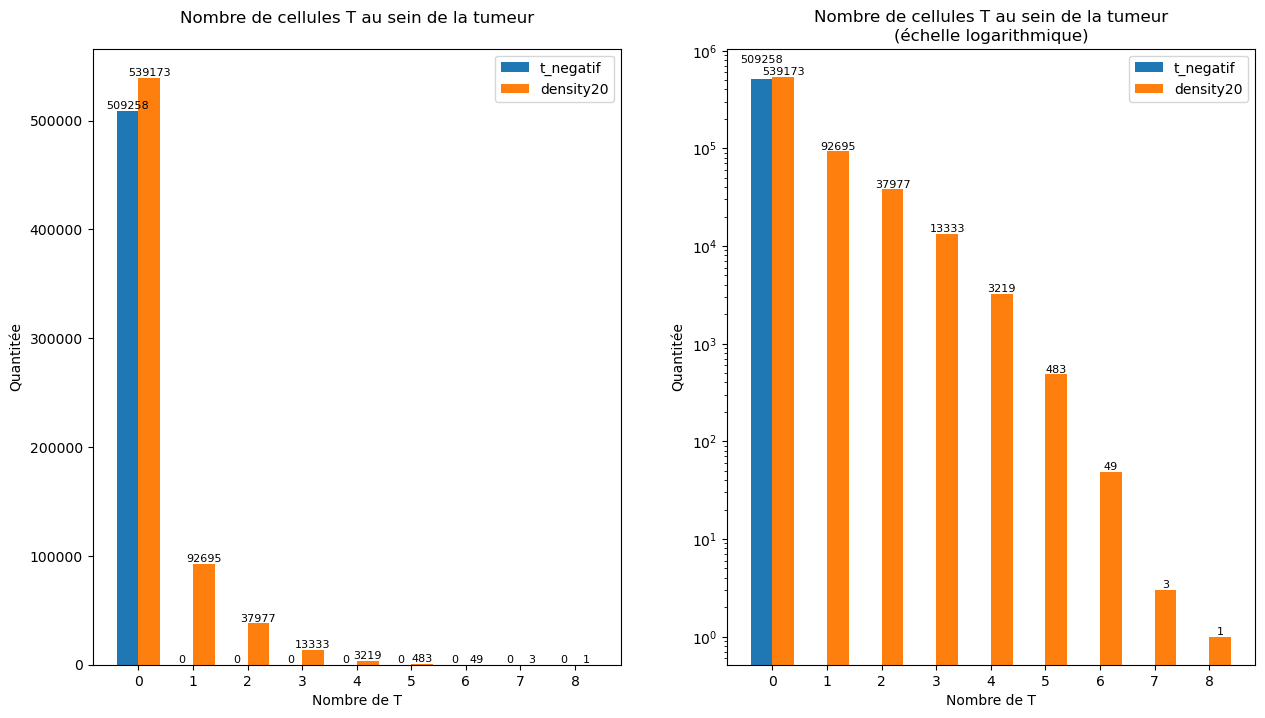

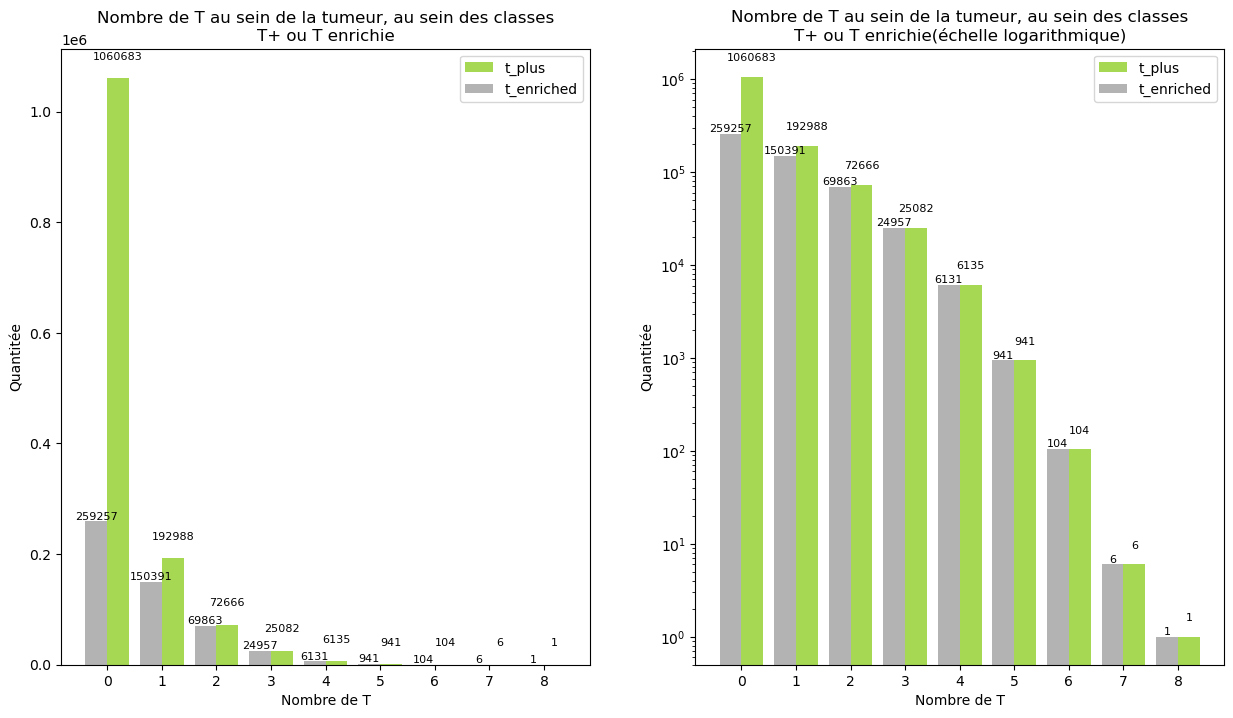

In [132]:
width = 0.4
## Number of observation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
ax1.bar(table_cd3["Cells"]-width/2, table_cd3["count_t_negatif"], width=width, label="t_negatif")
ax1.bar(table_cd3["Cells"]+width/2, table_cd3["count_density"], width=width, label="density20")
ax1.bar_label(ax1.containers[0], fontsize=8)
ax1.bar_label(ax1.containers[1], fontsize=8)
ax1.set_xticks(table_cd3["Cells"])
ax1.legend()

ax1.set_title("Nombre de cellules T au sein de la tumeur\n")
ax1.set_xlabel("Nombre de T")
ax1.set_ylabel("Quantitée")

ax2.bar(table_cd3["Cells"]+-width/2, table_cd3["count_t_negatif"], width=width, label="t_negatif")
ax2.bar(table_cd3["Cells"]+width/2, table_cd3["count_density"], width=width, label="density20")
ax2.bar_label(ax1.containers[0], padding=10, fontsize=8)
ax2.bar_label(ax1.containers[1], fontsize=8)
ax2.set_xticks(table_cd3["Cells"])
ax2.legend()
ax2.set_yscale("log")

ax2.set_title(
    "Nombre de cellules T au sein de la tumeur\n"
    "(échelle logarithmique)"
)
ax2.set_xlabel("Nombre de T")
ax2.set_ylabel("Quantitée")
plt.show()

## On t_enriched & t_plus
width = 0.4
## Number of observation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
ax1.bar(table_cd3["Cells"]+width/2, table_cd3["count_t_plus"], width=width, color=color_t_plus, label="t_plus")
ax1.bar(table_cd3["Cells"]+-width/2, table_cd3["count_t_enriched"], width=width, color=color_t_enriched, label="t_enriched")
ax1.bar_label(ax1.containers[0], padding=12, fontsize=8, fmt=lambda k: f"{k:.0f}")
ax1.bar_label(ax1.containers[1], fontsize=8, fmt=lambda k: f"{k:.0f}")
ax1.set_xticks(table_cd3["Cells"])
ax1.legend()

ax1.set_title("Nombre de T au sein de la tumeur, au sein des classes\nT+ ou T enrichie")
ax1.set_xlabel("Nombre de T")
ax1.set_ylabel("Quantitée")

ax2.bar(
    table_cd3["Cells"]+width/2, table_cd3["count_t_plus"], width=width, color=color_t_plus, label="t_plus"
)
ax2.bar(
    table_cd3["Cells"]+-width/2, table_cd3["count_t_enriched"], width=width, color=color_t_enriched, label="t_enriched"
)
ax2.bar_label(ax2.containers[0],  padding=10, fontsize=8, fmt=lambda k: f"{k:.0f}")
ax2.bar_label(ax2.containers[1], fontsize=8, fmt=lambda k: f"{k:.0f}")
ax2.set_xticks(table_cd3["Cells"])
ax2.legend()
ax2.set_yscale("log")

ax2.set_title(
    "Nombre de T au sein de la tumeur, au sein des classes\nT+ ou T enrichie\n"
    "(échelle logarithmique)"
)
ax2.set_xlabel("Nombre de T")
ax2.set_ylabel("Quantitée")
plt.show()

/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/etudiant/.conda/envs/BI/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

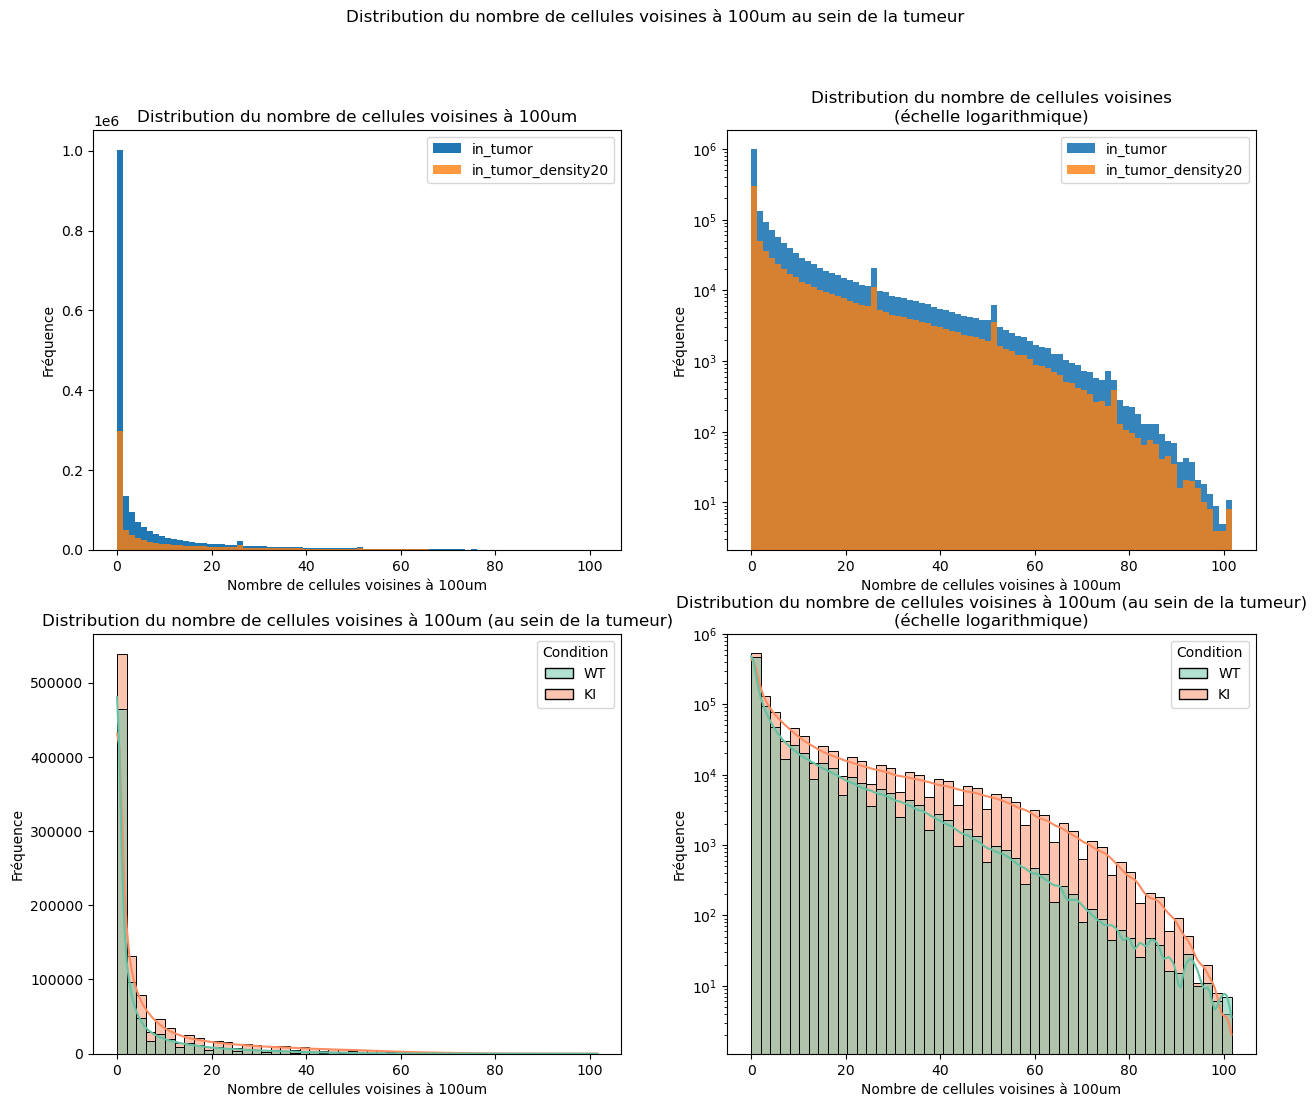

In [475]:
# Distribution du nombre de cellules voisines
#
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
ax1.hist(df_cd3_in_tumor["Cells100um"], bins=80, label="in_tumor")
ax1.hist(df_cd3_in_tumor[mask_density]["Cells100um"], bins=80, alpha=0.8, label="in_tumor_density20")
ax1.set_title("Distribution du nombre de cellules voisines à 100um")
ax1.set_xlabel("Nombre de cellules voisines à 100um")
ax1.set_ylabel("Fréquence")
ax1.legend()

ax2.hist(df_cd3_in_tumor["Cells100um"], bins=80, alpha=0.9, label="in_tumor")
ax2.hist(df_cd3_in_tumor[mask_density]["Cells100um"], bins=80, alpha=0.8, label="in_tumor_density20")
ax2.set_title("Distribution du nombre de cellules voisines\n(échelle logarithmique)")
ax2.set_xlabel("Nombre de cellules voisines à 100um")
ax2.set_ylabel("Fréquence")
ax2.set_yscale('log')
ax2.legend()

# wt & ki
sns.histplot(ax=ax3, data=df_cd3_in_tumor, hue="Condition", x="Cells100um", bins=50, palette=(color_wt, color_ki), kde=True)
#ax3.hist(df_cd3_in_tumor[mask_cd3_wt_in]["Cells100um"], bins=80, label="WT", color=)
#ax3.hist(df_cd3_in_tumor[mask_cd3_ki_in]["Cells100um"], bins=80, alpha=0.8, label="KI")
ax3.set_title("Distribution du nombre de cellules voisines à 100um (au sein de la tumeur)")
ax3.set_xlabel("Nombre de cellules voisines à 100um")
ax3.set_ylabel("Fréquence")

sns.histplot(ax=ax4, data=df_cd3_in_tumor, hue="Condition", x="Cells100um", bins=50, palette=(color_wt, color_ki), kde=True)
ax4.set_title("Distribution du nombre de cellules voisines à 100um (au sein de la tumeur)\n(échelle logarithmique)")
ax4.set_xlabel("Nombre de cellules voisines à 100um")
ax4.set_ylabel("Fréquence")
ax4.set_yscale('log')

plt.suptitle("Distribution du nombre de cellules voisines à 100um au sein de la tumeur\n")
plt.show()

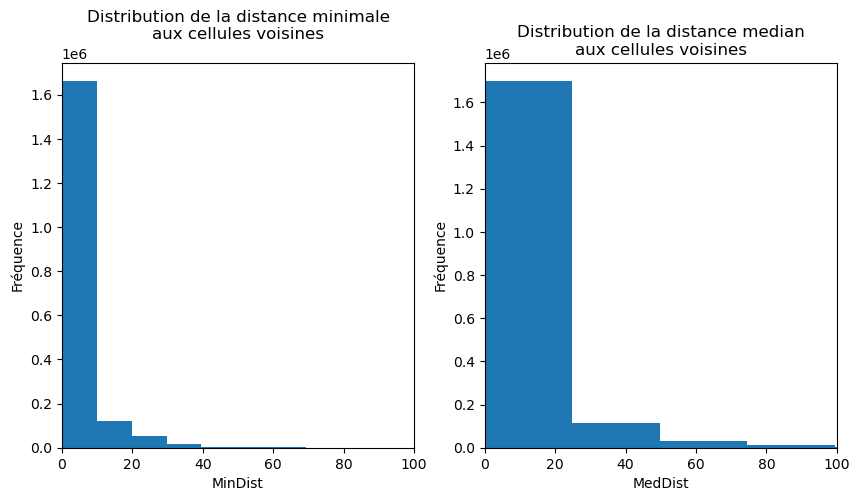

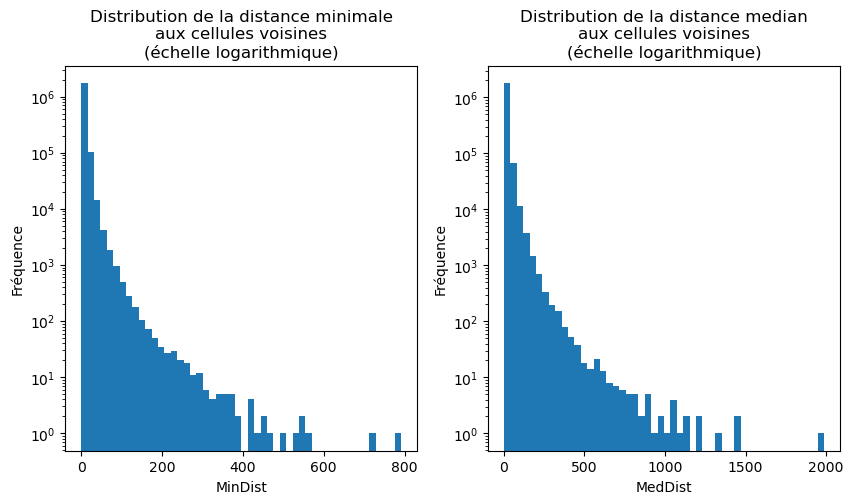

In [155]:
# Distance min & median aux cellules voisines
#
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(df_cd3_in_tumor["MinDist"], bins=80)
ax1.set_title("Distribution de la distance minimale\naux cellules voisines")
ax1.set_xlabel("MinDist")
ax1.set_ylabel("Fréquence")
ax1.set_xlim((0, 100))

ax2.hist(df_cd3_in_tumor["MedDist"], bins=80)
ax2.set_title("Distribution de la distance median\naux cellules voisines")
ax2.set_xlabel("MedDist")
ax2.set_ylabel("Fréquence")
ax2.set_xlim((0, 100))
plt.show()

# Log
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(df_cd3_in_tumor["MinDist"], bins=50)
ax1.set_title("Distribution de la distance minimale\naux cellules voisines\n(échelle logarithmique)")
ax1.set_xlabel("MinDist")
ax1.set_ylabel("Fréquence")
ax1.set_yscale('log')

ax2.hist(df_cd3_in_tumor["MedDist"], bins=50)
ax2.set_title("Distribution de la distance median\naux cellules voisines\n(échelle logarithmique)")
ax2.set_xlabel("MedDist")
ax2.set_ylabel("Fréquence")
ax2.set_yscale('log')
plt.show()

# TODO : WT/CD64
# TODO: Réduire x_lim
# CityPlot, DensityPlot, Field2D, ScatterPlot Facs - Flow Cytometry - Seaborn

### Analyse supervisée

L'objectif consiste à déterminer le set de descripteur nous permettant de caractériser les zones enrichies en cellules T, ainsi que les zones T+

In [107]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from matplotlib.legend_handler import HandlerLine2D

In [137]:
def forest_depth_acc(
    x_train, y_train, x_test, y_test,
    classifier=RandomForestClassifier,
    title="", depths=None, size=(9, 7), **kwargs
):
    max_depths = np.arange(10) + 1 if depths is None else depths
    train_results = []
    test_results = []
    # From depth 1 to n
    for max_depth in max_depths:
        # Train
        rf = classifier(max_depth=max_depth, **kwargs)
        rf.fit(x_train, y_train)  
        train_pred = rf.predict(x_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        # Test
        y_pred = rf.predict(x_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)

    return max_depths, train_results, test_results

#### T plus

##### Arbre de décision

**Jeu de données d'apprentissage et de validation**

In [209]:
x_columns = [
    *float_20_columns, *float_60_columns, *float_100_columns, *float_140_columns,
]
x_columns.remove("Angle20") ; x_columns.remove("Angle60") ; x_columns.remove("Angle100") ; x_columns.remove("Angle140")

x_columns_dist = [
    *float_20_columns, *float_60_columns, *float_100_columns, *float_140_columns,
    *distances_columns#, *shape_columns
]
X = df_cd3_zones_in.dropna()[x_columns].values
X_dist = df_cd3_zones_in.dropna()[x_columns_dist].values
Y = df_cd3_zones_in.dropna()["class_t_plus"].values  # t plus class

# Train and Validation set (to validate the model)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42, stratify=Y
)

# Train and Validation set & (Angle & Dist) (to validate the model)
X_dist_train, X_dist_test, Y_dist_train, Y_dist_test = train_test_split(
    X_dist, Y, test_size=0.3, random_state=42, stratify=Y
)

print(f"T plus")
print(f"Comptage des classes au sein de Y : {np.bincount(Y)}")
print(f"Comptage des classes au sein de Y_train : {np.bincount(Y_train)}")
print(f"Comptage des classes au sein de Y_test : {np.bincount(Y_test)}")

T plus
Comptage des classes au sein de Y : [146097 537802]
Comptage des classes au sein de Y_train : [102268 376461]
Comptage des classes au sein de Y_test : [ 43829 161341]


In [210]:
# Best number of depth
max_depths_clf, train_results_clf, test_results_clf = forest_depth_acc(
    X_train, Y_train, X_test, Y_test,
    depths=[2, 4, 6, 8, 10, 15, 20], 
    classifier=DecisionTreeClassifier,
)

# Best number of depth with Dist & Angle
max_dist_depths_clf, train_dist_results_clf, test_dist_results_clf = forest_depth_acc(
    X_dist_train, Y_dist_train, X_dist_test, Y_dist_test,
    depths=[2, 4, 6, 8, 10, 15, 20], 
    classifier=DecisionTreeClassifier,
)

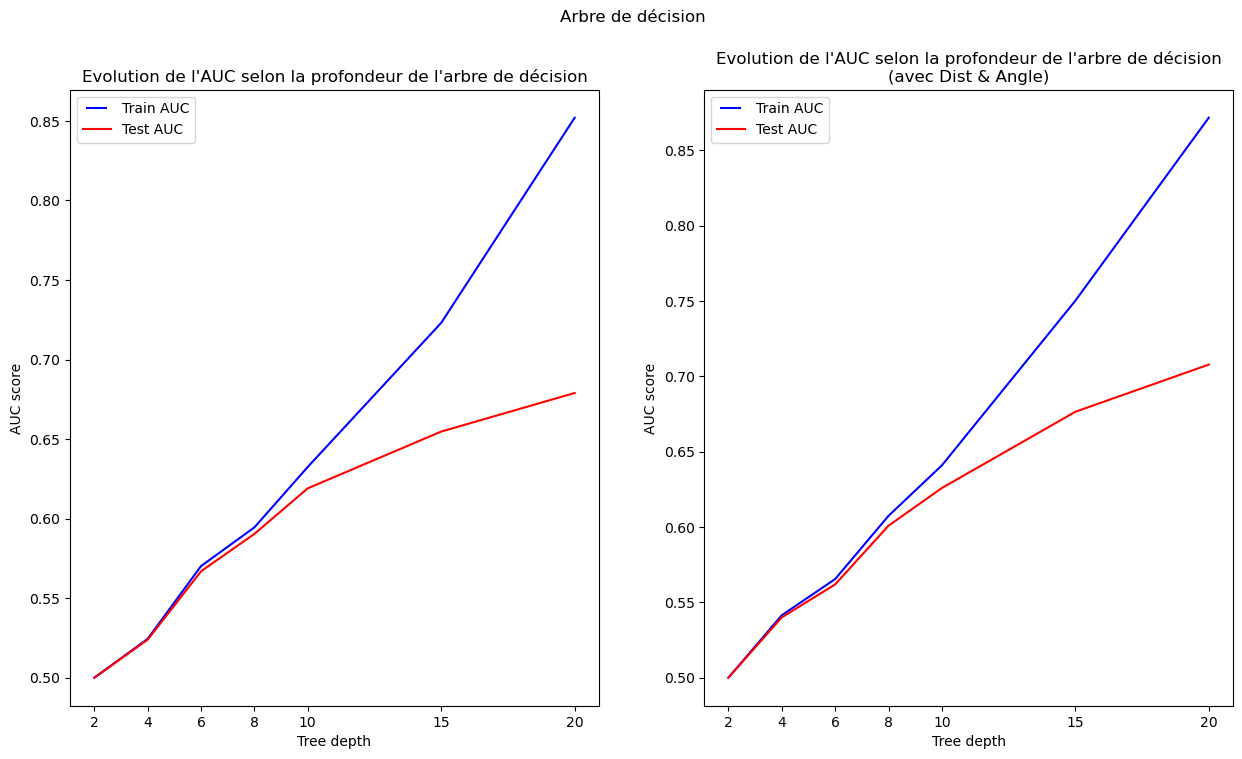

In [211]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
line1, = ax1.plot(max_depths_clf, train_results_clf, "b", label="Train AUC")
line2, = ax1.plot(max_depths_clf, test_results_clf, "r", label="Test AUC")
ax1.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
ax1.set_title("Evolution de l'AUC selon la profondeur de l'arbre de décision")
ax1.set_ylabel("AUC score")
ax1.set_xlabel("Tree depth")
ax1.set_xticks(max_depths_clf)

line1, = ax2.plot(max_depths_clf, train_dist_results_clf, "b", label="Train AUC")
line2, = ax2.plot(max_depths_clf, test_dist_results_clf, "r", label="Test AUC")
ax2.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
ax2.set_title("Evolution de l'AUC selon la profondeur de l'arbre de décision\n(avec Dist & Angle)")
ax2.set_ylabel("AUC score")
ax2.set_xlabel("Tree depth")
plt.suptitle("Arbre de décision")
ax2.set_xticks(max_depths_clf)
plt.show()

In [212]:
print(f"{'Profondeur':<15s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in max_depths] ; print()
print(f"{'AUC_train':<15s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in train_results] ; print()
print(f"{'AUC_test':<15s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in test_results] ; print("\n")
print(f"{'AUC_train_dist':<15s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in train_dist_results] ; print()
print(f"{'AUC_test_dist':<15s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in test_dist_results] ; print()

Profondeur     : 2     4     6     8     10    15    20    
AUC_train      : 0.50  0.52  0.57  0.59  0.63  0.72  0.85  
AUC_test       : 0.50  0.52  0.57  0.59  0.62  0.65  0.68  

AUC_train_dist : 0.50  0.54  0.57  0.61  0.64  0.75  0.87  
AUC_test_dist  : 0.50  0.54  0.56  0.60  0.63  0.68  0.71  


In [213]:
# Decision Tree (CART)
clf_plus = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=4,
    random_state=42
)

clf_plus.fit(X_train, Y_train)
y_train_pred = clf_plus.predict(X_train)
y_test_pred = clf_plus.predict(X_test)
clf_plus

# Decision Tree (CART) with Dist column
clf_dist_plus = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=4,
    random_state=42
)

clf_dist_plus.fit(X_dist_train, Y_dist_train)
y_dist_train_pred = clf_dist_plus.predict(X_dist_train)
y_dist_test_pred = clf_dist_plus.predict(X_dist_test)
clf_dist_plus

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)

In [214]:
false_pos_rate_train, true_pos_rate_train, _ = roc_curve(Y_train, y_train_pred)
false_pos_rate_test, true_pos_rate_test, _ = roc_curve(Y_test, y_test_pred)

false_pos_rate_dist_train, true_pos_rate_dist_train, _ = roc_curve(Y_dist_train, y_dist_train_pred)
false_pos_rate_dist_test, true_pos_rate_dist_test, _ = roc_curve(Y_dist_test, y_dist_test_pred)

# Model Accuracy, how often is the classifier correct?
print("Arbre de décision")
print("Accuracy Train:", accuracy_score(Y_train, y_train_pred))
print("AUC Train:", auc(false_pos_rate_train, true_pos_rate_train))
print()
print("Accuracy Test:", accuracy_score(Y_test, y_test_pred))
print("AUC Test:", auc(false_pos_rate_test, true_pos_rate_test))
print()

print("Arbre de décision acc, Angle avec Dist")
print("Accuracy Train:", accuracy_score(Y_dist_train, y_dist_train_pred))
print("AUC Train:", auc(false_pos_rate_dist_train, true_pos_rate_dist_train))
print()
print("Accuracy Test:", accuracy_score(Y_dist_test, y_dist_test_pred))
print("AUC Test:", auc(false_pos_rate_dist_test, true_pos_rate_dist_test))

# TODO : Matrice de Confusion (% de zones T associées aux T)
# Au sein des WT & KI, le % de zones T-
# Remplacer les valeurs des colonnes des obs T- par une valeur abérrante ?
# TODO : En équilibrant les classes
# TODO : T+ & (Density>)
## Matrice de Confusion
# TODO : Proportion des T+ et T- associées aux fibres ou non / fibres présence de T ou non
# TODO : Proportion de T enrichie, zones associées aux fibres ou non 
#
# TODO : densité/dist
# TODO : Dot plot

Arbre de décision
Accuracy Train: 0.7919846092465674
AUC Train: 0.5261888602228401

Accuracy Test: 0.7914509918604085
AUC Test: 0.5251118490867507

Arbre de décision acc, Angle avec Dist
Accuracy Train: 0.7927825554750182
AUC Train: 0.5430125175069653

Accuracy Test: 0.7915484719988303
AUC Test: 0.5412184035753698


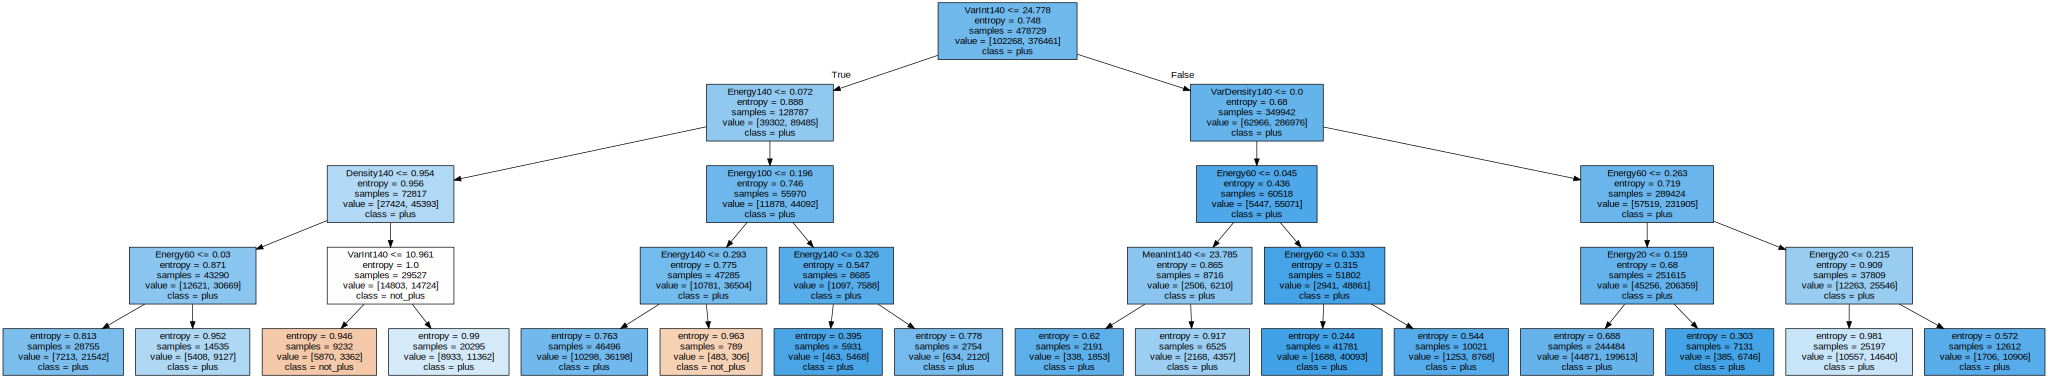

<Figure size 1000x1000 with 0 Axes>

In [215]:
# Arbre de Décision
fig = plt.figure(figsize=(10, 10))
dot_data = tree.export_graphviz(
    clf_plus,
    feature_names=x_columns,
    class_names=["not_plus", "plus"],
    filled=True
)
graph = graphviz.Source(dot_data, format="png")
graph.render("../out/decision_tree_t-plus")
graph

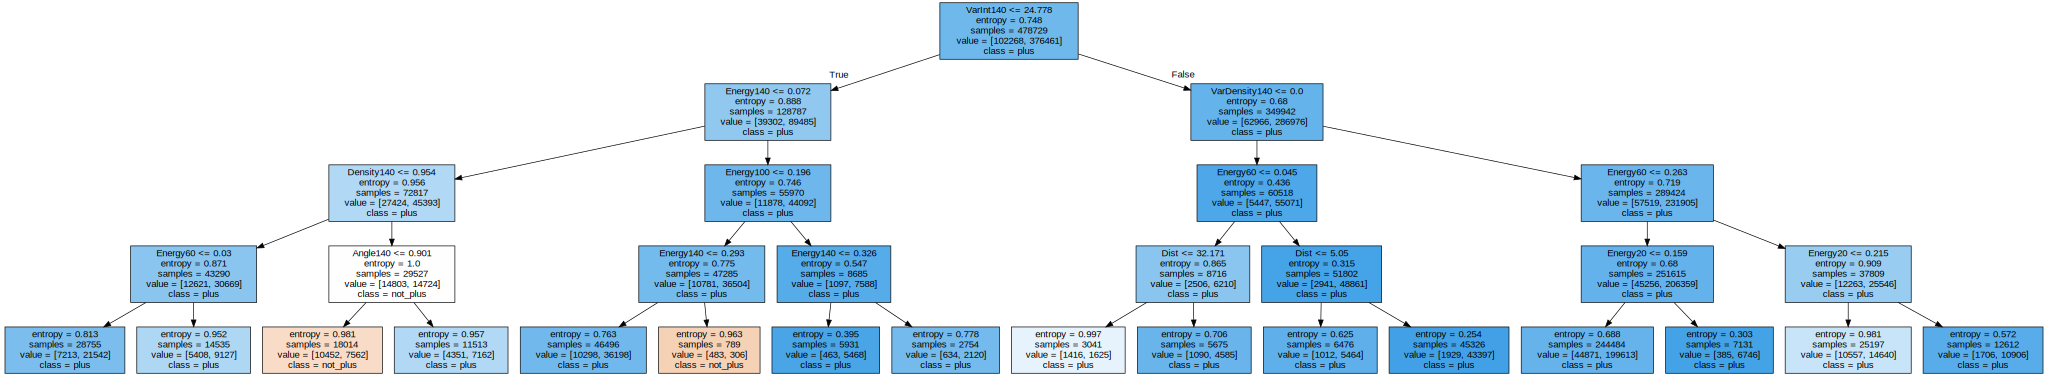

<Figure size 1000x1000 with 0 Axes>

In [216]:
# Arbre de décision avec l'ajout de Dist & Angle
fig = plt.figure(figsize=(10, 10))
dot_data = tree.export_graphviz(
    clf_dist_plus,
    feature_names=x_columns_dist,
    class_names=["not_plus", "plus"],
    filled=True
)
graph = graphviz.Source(dot_data, format="png")
graph.render("../out/decision_tree_t-plus_dist")
graph

##### Random Forest

In [217]:
max_depths_rd, train_results_rd, test_results_rd = forest_depth_acc(
    X_train, Y_train, X_test, Y_test,
    depths=[2, 4, 6, 8, 10, 15, 20], 
    classifier=RandomForestClassifier,
    n_estimators = 100,
    n_jobs=-1
)

max_dist_depths_rd, train_dist_results_rd, test_dist_results_rd = forest_depth_acc(
    X_dist_train, Y_dist_train, X_dist_test, Y_dist_test,
    depths=[2, 4, 6, 8, 10, 15, 20], 
    classifier=RandomForestClassifier,
    n_estimators = 100,
    n_jobs=-1
)

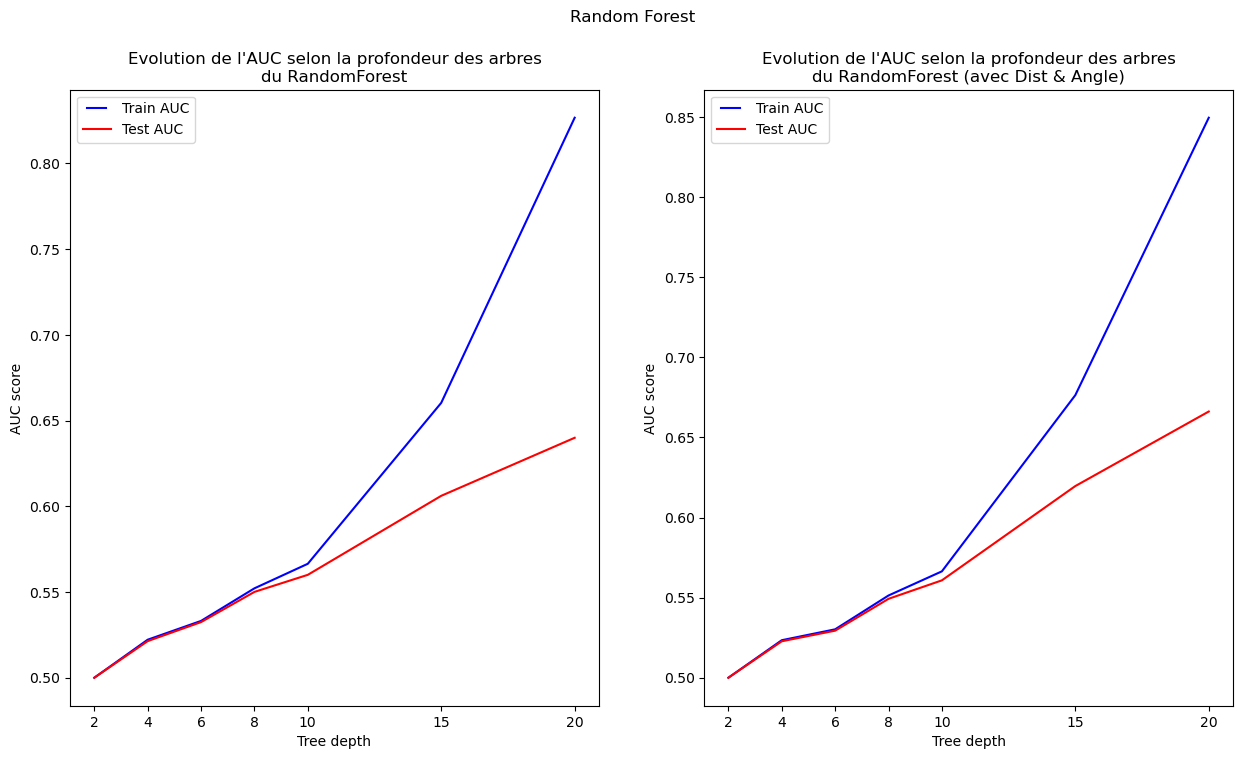

In [218]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
line1, = ax1.plot(max_depths_rd, train_results_rd, "b", label="Train AUC")
line2, = ax1.plot(max_depths_rd, test_results_rd, "r", label="Test AUC")
ax1.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
ax1.set_title("Evolution de l'AUC selon la profondeur des arbres\ndu RandomForest")
ax1.set_ylabel("AUC score")
ax1.set_xlabel("Tree depth")
ax1.set_xticks(max_depths_rd)

line1, = ax2.plot(max_dist_depths_rd, train_dist_results_rd, "b", label="Train AUC")
line2, = ax2.plot(max_dist_depths_rd, test_dist_results_rd, "r", label="Test AUC")
ax2.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
ax2.set_title("Evolution de l'AUC selon la profondeur des arbres\ndu RandomForest (avec Dist & Angle)")
ax2.set_ylabel("AUC score")
ax2.set_xlabel("Tree depth")
plt.suptitle("Random Forest")
ax2.set_xticks(max_dist_depths_rd)
plt.show()
# TODO : échelle y similaire

In [219]:
print(f"{'Profondeur':<15s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in max_depths_rd] ; print()
print(f"{'AUC_train':<15s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in train_results_rd] ; print()
print(f"{'AUC_test':<15s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in test_results_rd] ; print("\n")
print(f"{'AUC_train_dist':<15s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in train_dist_results_rd] ; print()
print(f"{'AUC_test_dist':<15s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in test_dist_results_rd] ; print()

Profondeur     : 2     4     6     8     10    15    20    
AUC_train      : 0.50  0.52  0.53  0.55  0.57  0.66  0.83  
AUC_test       : 0.50  0.52  0.53  0.55  0.56  0.61  0.64  

AUC_train_dist : 0.50  0.52  0.53  0.55  0.57  0.68  0.85  
AUC_test_dist  : 0.50  0.52  0.53  0.55  0.56  0.62  0.67  


In [220]:
# RandomForest model
rf_plus = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=5,
    n_jobs=-1
)

rf_plus.fit(X_train, Y_train)
y_train_pred = rf_plus.predict(X_train)
y_test_pred = rf_plus.predict(X_test)
rf_plus

# RandomForest model with Dist & Angle columns
rf_dist_plus = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=5,
    n_jobs=-1
)

rf_dist_plus.fit(X_dist_train, Y_dist_train)
y_dist_train_pred = rf_dist_plus.predict(X_dist_train)
y_dist_test_pred = rf_dist_plus.predict(X_dist_test)
rf_dist_plus

RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42)

In [221]:
# Model Accuracy, how often is the classifier correct?
y_train_pred = rf_plus.predict(X_train)
y_test_pred = rf_plus.predict(X_test)
y_dist_train_pred = rf_dist_plus.predict(X_dist_train)
y_dist_test_pred = rf_dist_plus.predict(X_dist_test)

In [222]:
# Model Accuracy, how often is the classifier correct?
false_pos_rate_train, true_pos_rate_train, _ = roc_curve(Y_train, y_train_pred)
false_pos_rate_test, true_pos_rate_test, _ = roc_curve(Y_test, y_test_pred)

false_pos_rate_dist_train, true_pos_rate_dist_train, _ = roc_curve(Y_dist_train, y_dist_train_pred)
false_pos_rate_dist_test, true_pos_rate_dist_test, _ = roc_curve(Y_dist_test, y_dist_test_pred)

# Model Accuracy, how often is the classifier correct?
print("Random Forest")
print("Accuracy Train:", accuracy_score(Y_train, y_train_pred))
print("AUC Train:", auc(false_pos_rate_train, true_pos_rate_train))
print()
print("Accuracy Test:", accuracy_score(Y_test, y_test_pred))
print("AUC Test:", auc(false_pos_rate_test, true_pos_rate_test))
print()

print("Random Forest, Angle avec Dist")
print("Accuracy Train:", accuracy_score(Y_dist_train, y_dist_train_pred))
print("AUC Train:", auc(false_pos_rate_dist_train, true_pos_rate_dist_train))
print()
print("Accuracy Test:", accuracy_score(Y_dist_test, y_dist_test_pred))
print("AUC Test:", auc(false_pos_rate_dist_test, true_pos_rate_dist_test))


Random Forest
Accuracy Train: 0.7929559312262261
AUC Train: 0.5265108947251915

Accuracy Test: 0.7923916751961788
AUC Test: 0.5259509205824769

Random Forest, Angle avec Dist
Accuracy Train: 0.7935763239745242
AUC Train: 0.5273469164466396

Accuracy Test: 0.7931227762343422
AUC Test: 0.5268229128600042


#### T enrichie

##### Arbre de décision

In [224]:
x_columns = [
    *float_20_columns, *float_60_columns, *float_100_columns, *float_140_columns,
]
x_columns.remove("Angle20") ; x_columns.remove("Angle60") ; x_columns.remove("Angle100") ; x_columns.remove("Angle140")

x_columns_dist = [
    *float_20_columns, *float_60_columns, *float_100_columns, *float_140_columns,
    *distances_columns#, *shape_columns
]
X = df_cd3_zones_in.dropna()[x_columns].values
X_dist = df_cd3_zones_in.dropna()[x_columns_dist].values
Y = df_cd3_zones_in.dropna()["class_t_enriched"].values  # t plus class

# Train and Validation set (to validate the model)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42, stratify=Y
)

# Train and Validation set & (Angle & Dist) (to validate the model)
X_dist_train, X_dist_test, Y_dist_train, Y_dist_test = train_test_split(
    X_dist, Y, test_size=0.3, random_state=42, stratify=Y
)

print(f"T enrichie")
print(f"Comptage des classes au sein de Y : {np.bincount(Y)}")
print(f"Comptage des classes au sein de Y_train : {np.bincount(Y_train)}")
print(f"Comptage des classes au sein de Y_test : {np.bincount(Y_test)}")

T enrichie
Comptage des classes au sein de Y : [431735 252164]
Comptage des classes au sein de Y_train : [302214 176515]
Comptage des classes au sein de Y_test : [129521  75649]


In [225]:
# Best number of depth
max_depths_clf, train_results_clf, test_results_clf = forest_depth_acc(
    X_train, Y_train, X_test, Y_test,
    depths=[2, 4, 6, 8, 10, 15, 20], 
    classifier=DecisionTreeClassifier,
)

# Best number of depth with Dist & Angle
max_dist_depths_clf, train_dist_results_clf, test_dist_results_clf = forest_depth_acc(
    X_dist_train, Y_dist_train, X_dist_test, Y_dist_test,
    depths=[2, 4, 6, 8, 10, 15, 20], 
    classifier=DecisionTreeClassifier,
)

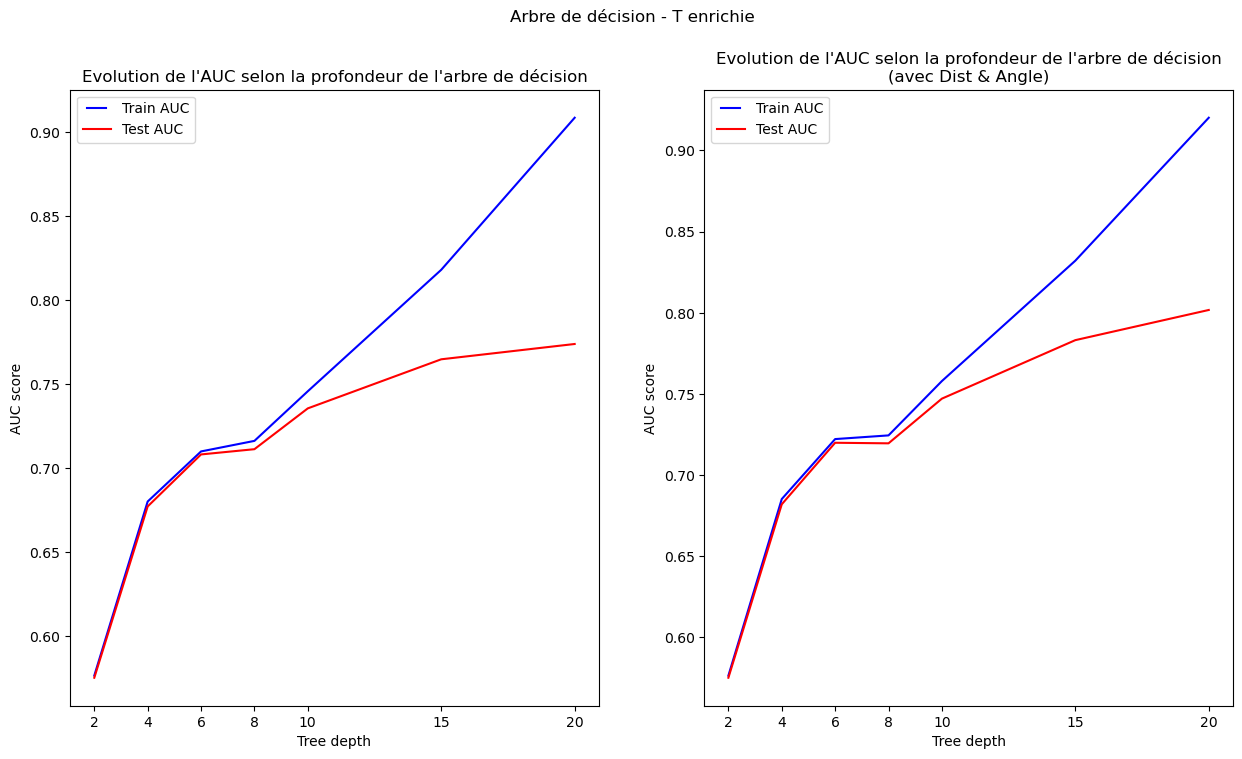

In [190]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
line1, = ax1.plot(max_depths_clf, train_results_clf, "b", label="Train AUC")
line2, = ax1.plot(max_depths_clf, test_results_clf, "r", label="Test AUC")
ax1.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
ax1.set_title("Evolution de l'AUC selon la profondeur de l'arbre de décision")
ax1.set_ylabel("AUC score")
ax1.set_xlabel("Tree depth")
ax1.set_xticks(max_depths_clf)

line1, = ax2.plot(max_depths_clf, train_dist_results_clf, "b", label="Train AUC")
line2, = ax2.plot(max_depths_clf, test_dist_results_clf, "r", label="Test AUC")
ax2.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
ax2.set_title("Evolution de l'AUC selon la profondeur de l'arbre de décision\n(avec Dist & Angle)")
ax2.set_ylabel("AUC score")
ax2.set_xlabel("Tree depth")
plt.suptitle("Arbre de décision - T enrichie")
ax2.set_xticks(max_depths_clf)
plt.show()

In [ ]:
# TODO : Quels sont les zones T+/T enrichies mal prédites
# TODO : Comparer T+ et T enrichie
# TODO : Seuil plus haut pour la classe T enrichie, 

In [191]:
print(f"{'Profondeur':<15s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in max_depths] ; print()
print(f"{'AUC_train':<15s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in train_results] ; print()
print(f"{'AUC_test':<15s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in test_results] ; print("\n")
print(f"{'AUC_train_dist':<15s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in train_dist_results] ; print()
print(f"{'AUC_test_dist':<15s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in test_dist_results] ; print()

Profondeur     : 2     4     6     8     10    15    20    
AUC_train      : 0.50  0.52  0.57  0.59  0.63  0.72  0.85  
AUC_test       : 0.50  0.52  0.57  0.59  0.62  0.65  0.68  

AUC_train_dist : 0.50  0.54  0.57  0.61  0.64  0.75  0.87  
AUC_test_dist  : 0.50  0.54  0.56  0.60  0.63  0.68  0.71  


In [192]:
# Decision Tree (CART)
clf_plus = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=4,
    random_state=42
)

clf_plus.fit(X_train, Y_train)
y_train_pred = clf_plus.predict(X_train)
y_test_pred = clf_plus.predict(X_test)
clf_plus

# Decision Tree (CART) with Dist column
clf_dist_plus = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=4,
    random_state=42
)

clf_dist_plus.fit(X_dist_train, Y_dist_train)
y_dist_train_pred = clf_dist_plus.predict(X_dist_train)
y_dist_test_pred = clf_dist_plus.predict(X_dist_test)
clf_dist_plus

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)

In [193]:
false_pos_rate_train, true_pos_rate_train, _ = roc_curve(Y_train, y_train_pred)
false_pos_rate_test, true_pos_rate_test, _ = roc_curve(Y_test, y_test_pred)

false_pos_rate_dist_train, true_pos_rate_dist_train, _ = roc_curve(Y_dist_train, y_dist_train_pred)
false_pos_rate_dist_test, true_pos_rate_dist_test, _ = roc_curve(Y_dist_test, y_dist_test_pred)

# Model Accuracy, how often is the classifier correct?
print("Arbre de décision")
print("Accuracy Train:", accuracy_score(Y_train, y_train_pred))
print("AUC Train:", auc(false_pos_rate_train, true_pos_rate_train))
print()
print("Accuracy Test:", accuracy_score(Y_test, y_test_pred))
print("AUC Test:", auc(false_pos_rate_test, true_pos_rate_test))
print()

print("Arbre de décision acc, Angle avec Dist")
print("Accuracy Train:", accuracy_score(Y_dist_train, y_dist_train_pred))
print("AUC Train:", auc(false_pos_rate_dist_train, true_pos_rate_dist_train))
print()
print("Accuracy Test:", accuracy_score(Y_dist_test, y_dist_test_pred))
print("AUC Test:", auc(false_pos_rate_dist_test, true_pos_rate_dist_test))


Arbre de décision
Accuracy Train: 0.6930768764791772
Accuracy Test: 0.6935273188087927

Arbre de décision acc, Angle avec Dist
Accuracy Train: 0.6945453482032632
Accuracy Test: 0.694355899985378


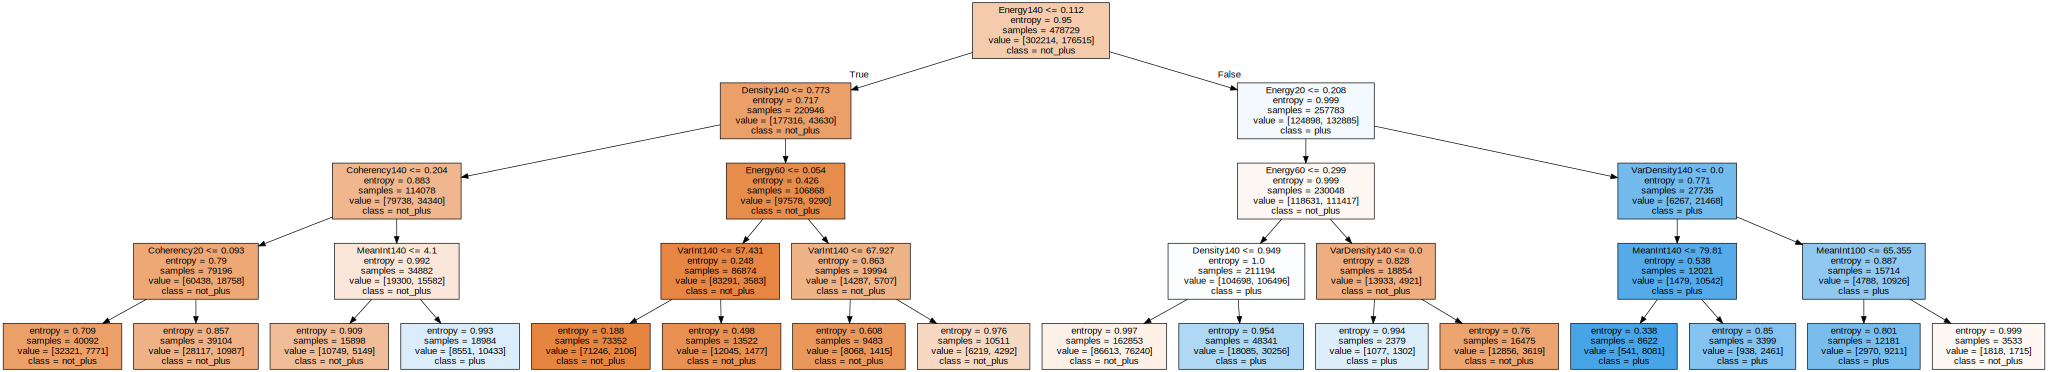

<Figure size 1000x1000 with 0 Axes>

In [194]:
# Arbre de Décision
fig = plt.figure(figsize=(10, 10))
dot_data = tree.export_graphviz(
    clf_plus,
    feature_names=x_columns,
    class_names=["not_plus", "plus"],
    filled=True
)
graph = graphviz.Source(dot_data, format="png")
graph.render("../out/decision_tree_t-enriched")
graph

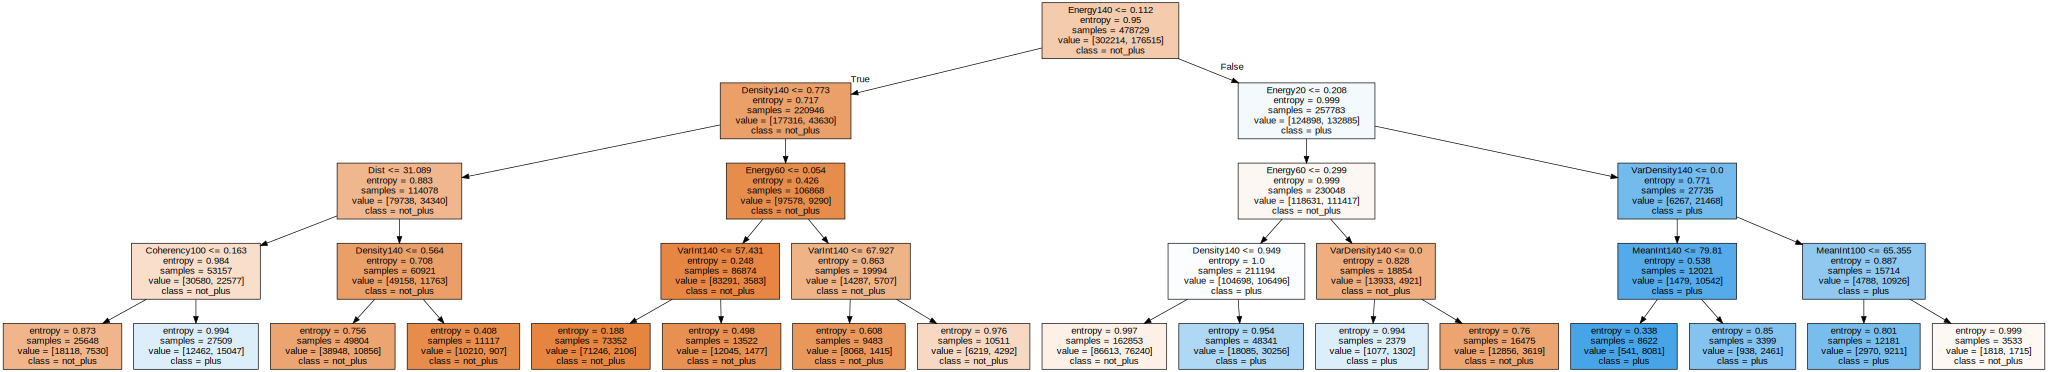

<Figure size 1000x1000 with 0 Axes>

In [195]:
# Arbre de décision avec l'ajout de Dist & Angle
fig = plt.figure(figsize=(10, 10))
dot_data = tree.export_graphviz(
    clf_dist_plus,
    feature_names=x_columns_dist,
    class_names=["not_plus", "plus"],
    filled=True
)
graph = graphviz.Source(dot_data, format="png")
graph.render("../out/decision_tree_t-enriched_dist")
graph

##### Random Forest

TODO: expliquer la méthode

In [196]:
max_depths_rd, train_results_rd, test_results_rd = forest_depth_acc(
    X_train, Y_train, X_test, Y_test,
    depths=[2, 4, 6, 8, 10, 15, 20], 
    classifier=RandomForestClassifier,
    n_estimators = 100,
    n_jobs=-1
)

max_dist_depths_rd, train_dist_results_rd, test_dist_results_rd = forest_depth_acc(
    X_dist_train, Y_dist_train, X_dist_test, Y_dist_test,
    depths=[2, 4, 6, 8, 10, 15, 20], 
    classifier=RandomForestClassifier,
    n_estimators = 100,
    n_jobs=-1
)

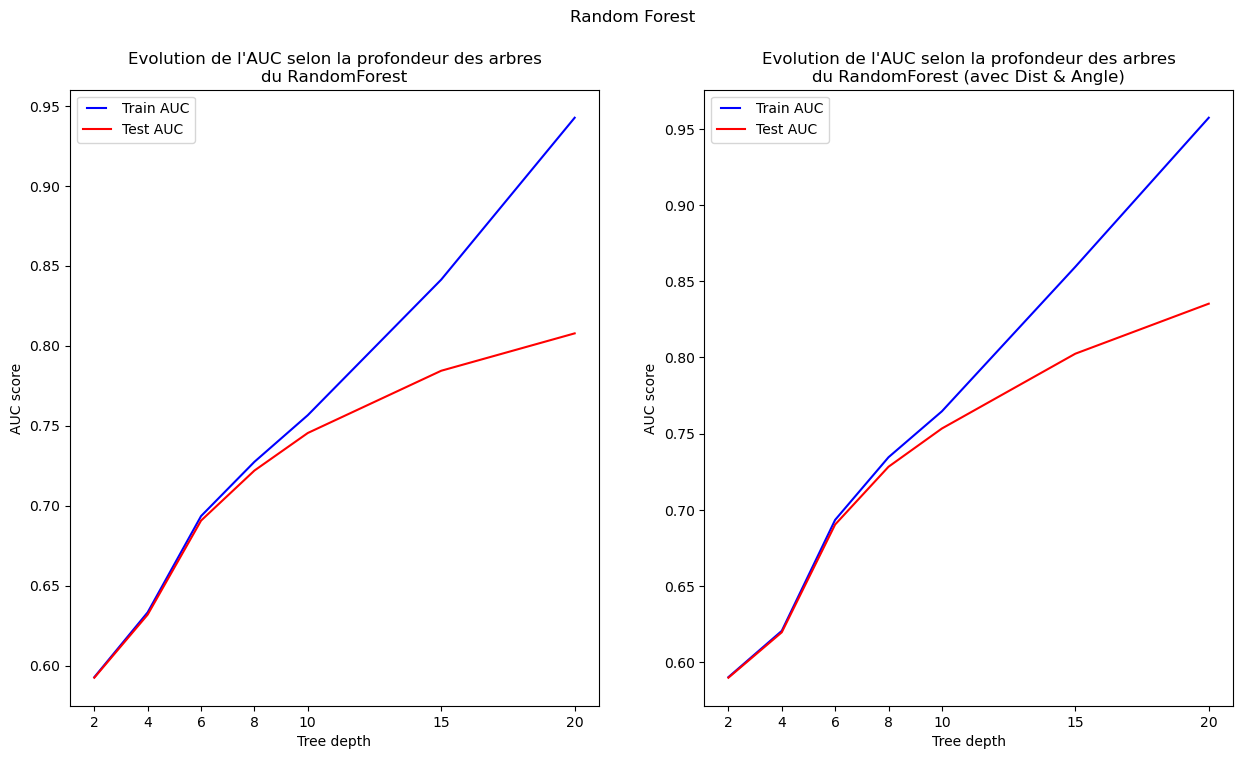

In [197]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
line1, = ax1.plot(max_depths_rd, train_results_rd, "b", label="Train AUC")
line2, = ax1.plot(max_depths_rd, test_results_rd, "r", label="Test AUC")
ax1.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
ax1.set_title("Evolution de l'AUC selon la profondeur des arbres\ndu RandomForest")
ax1.set_ylabel("AUC score")
ax1.set_xlabel("Tree depth")
ax1.set_xticks(max_depths_rd)

line1, = ax2.plot(max_dist_depths_rd, train_dist_results_rd, "b", label="Train AUC")
line2, = ax2.plot(max_dist_depths_rd, test_dist_results_rd, "r", label="Test AUC")
ax2.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
ax2.set_title("Evolution de l'AUC selon la profondeur des arbres\ndu RandomForest (avec Dist & Angle)")
ax2.set_ylabel("AUC score")
ax2.set_xlabel("Tree depth")
plt.suptitle("Random Forest")
ax2.set_xticks(max_dist_depths_rd)
plt.show()

In [198]:
print(f"{'Profondeur':<15s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in max_depths_rd] ; print()
print(f"{'AUC_train':<15s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in train_results_rd] ; print()
print(f"{'AUC_test':<15s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in test_results_rd] ; print("\n")
print(f"{'AUC_train_dist':<15s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in train_dist_results_rd] ; print()
print(f"{'AUC_test_dist':<15s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in test_dist_results_rd] ; print()
yhnu,j;ojk;;;;l:::m!#çu:;(=b

Profondeur     : 2     4     6     8     10    15    20    
AUC_train      : 0.59  0.63  0.69  0.73  0.76  0.84  0.94  
AUC_test       : 0.59  0.63  0.69  0.72  0.75  0.78  0.81  

AUC_train_dist : 0.59  0.62  0.69  0.73  0.76  0.86  0.96  
AUC_test_dist  : 0.59  0.62  0.69  0.73  0.75  0.80  0.84  


In [231]:
# RandomForest model
rf_enriched = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=15,
    n_jobs=-1
)
rf_enriched.fit(X_train, Y_train)
y_train_pred = rf_enriched.predict(X_train)
y_test_pred = rf_enriched.predict(X_test)
rf_enriched

# RandomForest model with Dist & Angle columns
rf_dist_enriched = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=15,
    n_jobs=-1
)

rf_dist_enriched.fit(X_dist_train, Y_dist_train)
y_dist_train_pred = rf_dist_enriched.predict(X_dist_train)
y_dist_test_pred = rf_dist_enriched.predict(X_dist_test)
rf_dist_enriched

RandomForestClassifier(max_depth=15, n_jobs=-1, random_state=42)

In [232]:
# Model Accuracy, how often is the classifier correct?
y_train_pred = rf_enriched.predict(X_train)
y_test_pred = rf_enriched.predict(X_test)
y_dist_train_pred = rf_dist_enriched.predict(X_dist_train)
y_dist_test_pred = rf_dist_enriched.predict(X_dist_test)

In [233]:
false_pos_rate_train, true_pos_rate_train, _ = roc_curve(Y_train, y_train_pred)
false_pos_rate_test, true_pos_rate_test, _ = roc_curve(Y_test, y_test_pred)

false_pos_rate_dist_train, true_pos_rate_dist_train, _ = roc_curve(Y_dist_train, y_dist_train_pred)
false_pos_rate_dist_test, true_pos_rate_dist_test, _ = roc_curve(Y_dist_test, y_dist_test_pred)

# Model Accuracy, how often is the classifier correct?
print("Random Forest")
print("Accuracy Train:", accuracy_score(Y_train, y_train_pred))
print("AUC Train:", auc(false_pos_rate_train, true_pos_rate_train))
print()
print("Accuracy Test:", accuracy_score(Y_test, y_test_pred))
print("AUC Test:", auc(false_pos_rate_test, true_pos_rate_test))
print()

print("Random Forest, Angle avec Dist")
print("Accuracy Train:", accuracy_score(Y_dist_train, y_dist_train_pred))
print("AUC Train:", auc(false_pos_rate_dist_train, true_pos_rate_dist_train))
print()
print("Accuracy Test:", accuracy_score(Y_dist_test, y_dist_test_pred))
print("AUC Test:", auc(false_pos_rate_dist_test, true_pos_rate_dist_test))


Random Forest
Accuracy Train: 0.8634968844586395
AUC Train: 0.8408040940479249

Accuracy Test: 0.8129794804308622
AUC Test: 0.7839982897115125

Random Forest, Angle avec Dist
Accuracy Train: 0.8806631726926926
AUC Train: 0.8603631062225038

Accuracy Test: 0.8309158259004727
AUC Test: 0.8040710486072996


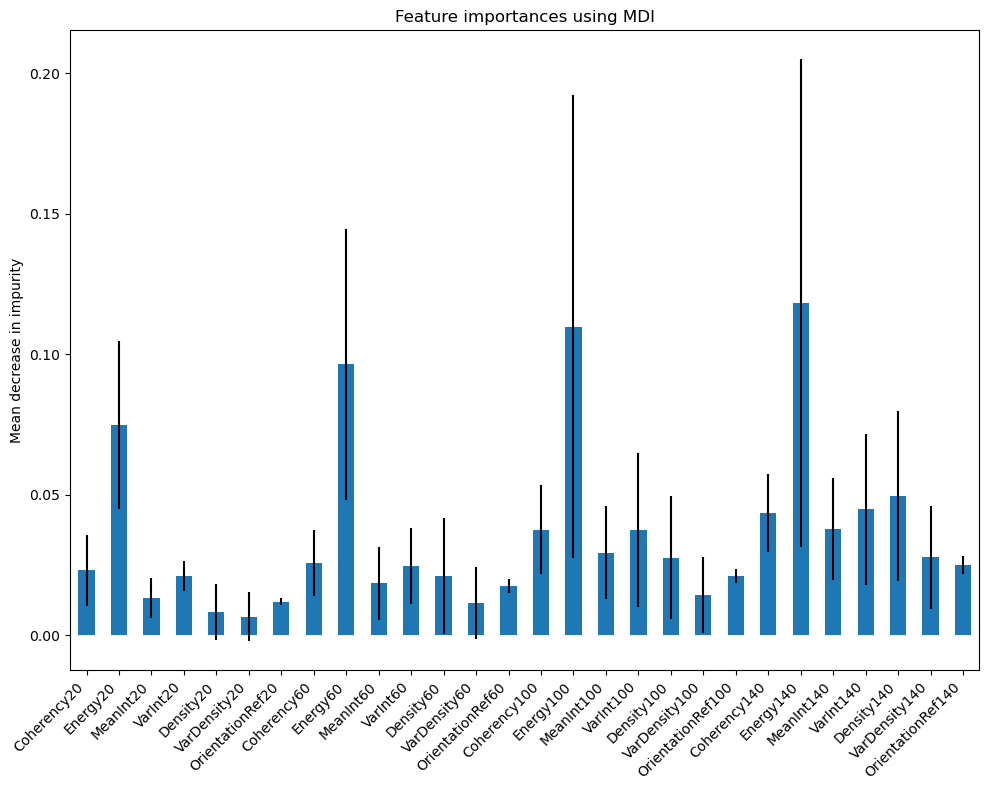

In [234]:
importances = rf_enriched.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_enriched.estimators_], axis=0)
forest_importances = pd.Series(importances, index=x_columns)

fig, ax = plt.subplots(figsize=(10, 8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks(rotation=45, ha='right')
fig.tight_layout()

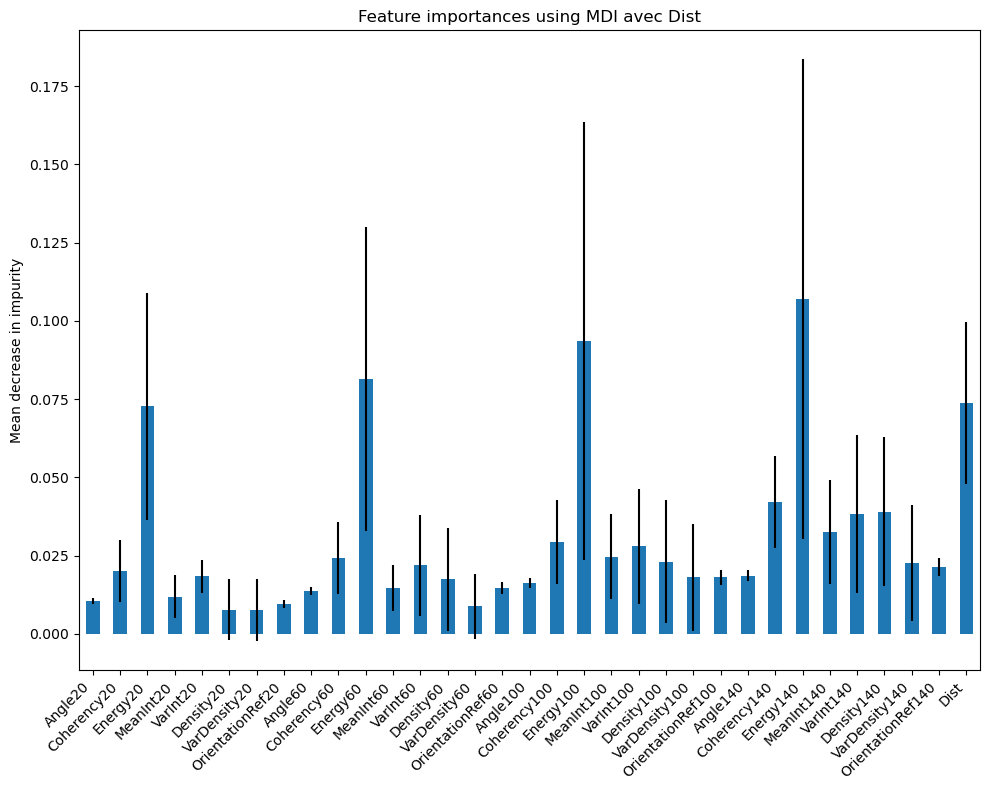

In [235]:
importances = rf_dist_enriched.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_dist_enriched.estimators_], axis=0)
forest_importances = pd.Series(importances, index=x_columns_dist)

fig, ax = plt.subplots(figsize=(10, 8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI avec Dist")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks(rotation=45, ha='right')
fig.tight_layout()

## Nombre de Cellules T
### Analyse supervisée

In [ ]:
from sklearn.cross_decomposition import PLS

pls2 = PLSRegression(n_components=2)
pls2.fit(X, Y)
y_pred = rf.predict(X_test)

In [ ]:
plt.scatter(pls2.transform(X)[:, 0], Y)
plt.scatter(pls2.transform(X)[:, 0], pls2.predict(X))

In [ ]:


rf = RandomForestRegressor(n_estimators=3, random_state=42)
rf.fit(X, Y.ravel())

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

## Classification non hiérarchique des types de fibres

Nous nous intéressons à l'identification de classes permettant de caractériser la topologie des réseaux au sein de notre jeu de données.

In [ ]:
df_cd3_density = df_cd3_in_tumor[df_cd3_in_tumor["Density20"] > 0]
X = df_cd3_density.dropna()[x_columns].drop(columns=["Frac"]).values
Y = df_cd3_density.dropna()[y_columns].values

In [ ]:
f"{X.shape} {Y.shape}"

In [ ]:
x_columns

In [ ]:
df_cd3_density.isna().sum()

In [ ]:
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

In [ ]:
km = KMeans(n_clusters=4, n_init=50)
km.fit(X)
X_kmeans = km.transform(X)

In [ ]:
pca = PCA(n_components=6)
pca.fit(X)
X_pca = pca.transform(X)

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km.labels_, alpha=0.5)

In [ ]:
## Cell with density
i = 2
name = df_cd3_perfile_in_tumor.index[i]
df_cd3_in_tumor_bis = df_cd3_in_tumor.copy()
fiber_class = km.predict(df_cd3_in_tumor_bis[x_columns].drop(columns=["Frac"]))
df_cd3_in_tumor_bis["class"] = fiber_class
# Show density
m = ExtractMap.ExtractMap(df_cd3_in_tumor_bis, "Density20", choose=name)
plt.imshow(m)
# Show T Cells
p = ExtractMap.ExtractMap(df_cd3_in_tumor_bis, "class", choose=name)
p[p == 0] = np.nan
plt.imshow(p, cmap=plt.cm.Reds)
plt.title(f"{df_cd3_perfile_in_tumor['Name'].iloc[i]}\n{df_cd3_perfile_in_tumor['Condition'].iloc[i]}")
plt.show()